## Import packages and set up default matplotlib plotting parameters

In [1]:
#import packages
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import scipy
import scipy.stats
import scipy.integrate
import  scipy.signal
from scipy.stats import spearmanr,pearsonr

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import colors
from matplotlib.patches import Rectangle

import seaborn as sns # another plotting package

import pyleoclim as pyleo
from pyleoclim import utils
from pyleoclim.utils import tsutils
#utils.plotting.set_style(style='matplotlib', font_scale=1.0)
matplotlib.rcParams.update(plt.rcParamsDefault)

import matplotlib.patheffects as path

import trendvis as tv

#Set up default plot properties
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
font = {'weight' : 'normal',
        'size'   : 12}
half_width=3.5 #width of 1/2 page figure
full_width=7 #with of full page figure

matplotlib.rc('font', **font)

#create figures directory if doesn't exist already
import os
os.makedirs('figures', exist_ok=True) 

## Load in bulk and compound-specific d13C & d15N, C/N and Mol% Datasets

In [2]:
#Load bulk data
bulk_D639_1C=pd.read_csv('datasets/D639_1C_bulk.csv')
bulk_D621_1B=pd.read_csv('datasets/D621_1B_bulk.csv')
bulk_data=pd.concat([bulk_D639_1C, bulk_D621_1B], sort=False).sort_values(by='Age Model')

# load csi-aa N and C data
N_df=pd.read_csv('datasets/csiaa_n.csv')
C_df=pd.read_csv('datasets/csiaa_c.csv')

# merge bulk d15N and csi-aa N data into one dataframe 
N_df=pd.merge(N_df, bulk_data, how='outer', left_on=['Coral ID','Sample #'], right_on=['Coral ID','Sample #']).dropna(how='any')
AA_d15N=N_df.loc[:,['Coral ID','Sample #','Age Model','d15N', 
                    'Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val',
                    'Gly','Ser','Lys','Phe', 'Thr']]
AA_d15Nstd=N_df.loc[:,['Coral ID','Sample #', 'Age Model', 
                       'Glu_std', 'Asp_std', 'Ala_std','Ile_std','Leu_std','Pro+Hpro_std','Val_std',
                       'Gly_std','Ser_std','Lys_std','Phe_std', 'Thr_std']]

# merge bulk d13C and csi-aa C data into one dataframe 
C_df=pd.merge(C_df, bulk_data, how='outer', left_on=['Coral ID','Sample #'], right_on=['Coral ID','Sample #']).dropna(how='any')
AA_d13C=C_df.loc[:,['Coral ID','Sample #','Age Model', 'd13C', 'Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']]
AA_d13Cstd=C_df.loc[:,['Coral ID', 'Sample #', 'Age Model', 'Gly_std', 'Ser_std', 'Asp_std','Glu_std','Pro_std', 'Ala_std','Thr_std','Ile_std','Val_std','Phe_std','Leu_std','Lys_std']]

#sort data in chronological order
AA_d15N=AA_d15N.sort_values(by='Age Model').reset_index()
AA_d15Nstd=AA_d15Nstd.sort_values(by='Age Model').reset_index()
AA_d13C=AA_d13C.sort_values(by='Age Model').reset_index()
AA_d13Cstd=AA_d13Cstd.sort_values(by='Age Model').reset_index()

#load mol perc data
mol_perc=pd.read_csv('datasets/mol_percents.csv')
molperc_means=mol_perc.iloc[:,2:].mean()/100 
molperc_stds=mol_perc.iloc[:,2:].std()/100

#load amino acid C and N counts
AA_C_N_df=pd.read_csv('datasets/aa_atomic_CN_counts.csv')
AA_num_C,AA_num_N=AA_C_N_df.iloc[0,1:],AA_C_N_df.iloc[1,1:]

## Load in oceanography and climate datasets and calculate 3yr running means, detrending, etc

In [3]:
#pacific grove daily sst from https://zenodo.org/records/7041718
PG_SST=pd.read_csv('datasets/HMS_SST_corrected_1919-2020.csv') # load dataset
PG_SST['date'] = pd.to_datetime(PG_SST['Date']) #create a datetime field in sst dataframe
SST_monthly=PG_SST.resample('M', on='date').mean(numeric_only=True) #resample to monthly resolution
SST_monthly['date']=SST_monthly.index #set date to the index for the sst monthly dataframe

SST_annual=SST_monthly.resample('Y').mean(numeric_only=True) #resample to annual resolution
SST_annual['SST_annual_3yr_movavg']=SST_annual['SST'].rolling(window=3,min_periods=3,center=True).mean() #compute three year rolling mean
SST_annual=SST_annual.dropna() #drop nans from dataset
SST_annual['SST_annual_3yr_movavg_detrend']=scipy.signal.detrend(SST_annual['SST_annual_3yr_movavg']) #detrend annual SST timeseries
SST_annual=SST_annual.reset_index()

SST_upseason=SST_monthly.loc[SST_monthly['date'].dt.month.between(4,8)].resample('Y',on='date').mean() #compute three year rolling mean for apr-aug upwelling season
SST_upseason['SST_upseason_3yr_movavg']=SST_upseason['SST'].rolling(window=3,min_periods=3,center=True).mean()  #compute three year rolling mean
SST_upseason=SST_upseason.dropna() #drop nans
SST_upseason['SST_upseason_3yr_movavg_detrend']=scipy.signal.detrend(SST_upseason['SST_upseason_3yr_movavg']) #detrend upwelling season SST timeseries
SST_upseason=SST_upseason.reset_index()

#load monthly PDO data
#from http://research.jisao.washington.edu/pdo/PDO.latest.txt
PDO=pd.read_csv('datasets/PDO_data.csv') #load dataset

#convert from 2d into 1d array with columns for month and year
PDO=PDO.iloc[:,0:13].set_index('Year') 
PDO.columns = range(1, 13)
PDO.columns.name = 'month'
PDO_monthly=PDO.stack()
PDO_monthly.name='PDO'
PDO_monthly=PDO_monthly.reset_index()

PDO_monthly=PDO_monthly.loc[(PDO_monthly['Year'] > 1899) & (PDO_monthly['Year'] < 2018)] #select desired time range
PDO_monthly=PDO_monthly.reset_index() #reset index
PDO_monthly['date']=pd.to_datetime(pd.DataFrame({'day': 1,'month': PDO_monthly.month,
                                                 'year': PDO_monthly.Year}))

PDO_annual=PDO_monthly.resample('Y', on='date').mean() #resample to annual resolution
PDO_annual['PDO_annual_3yr_movavg']=PDO_annual['PDO'].rolling(window=3,min_periods=3,center=True).mean() #compute 3 yr running mean
PDO_annual=PDO_annual.dropna() #drop nans
PDO_annual=PDO_annual.reset_index()

## Calculations for bamboo coral isotope variables

### First carbon:

In [4]:
#CSI-AA d13C calculations Sur Ridge Coral

#calculate d13C of average essential and nonessential AAs
AA_d13C['avg nonessential'] = AA_d13C[['Gly', 'Ser', 'Asp','Glu','Pro','Ala']].mean(axis=1)
AA_d13Cstd['avg nonessential'] = (((AA_d13Cstd['Gly_std']**2)+(AA_d13Cstd['Ser_std']**2)+
                                       (AA_d13Cstd['Asp_std']**2)+(AA_d13Cstd['Glu_std']**2)+
                                       (AA_d13Cstd['Pro_std']**2)+(AA_d13Cstd['Ala_std']**2))**(.5))/6

AA_d13C['avg essential'] = AA_d13C[['Thr', 'Ile','Phe','Leu','Lys']].mean(axis=1)
AA_d13Cstd['avg essential'] = (((AA_d13Cstd['Thr_std']**2)+(AA_d13Cstd['Ile_std']**2)+
                                    +(AA_d13Cstd['Phe_std']**2)+
                                    (AA_d13Cstd['Leu_std']**2)+(AA_d13Cstd['Lys_std']**2))**(0.5))/5

# Calculations for atomic weighted THAA
atomic_Cwts_sum=np.sum(AA_num_C*molperc_means)
atomic_Cwts_sum_std=(((AA_num_C*molperc_stds)**2).sum())**0.5


atomic_C_wts=(AA_num_C*molperc_means)/atomic_Cwts_sum
atomic_C_wts_std=((((AA_num_C/atomic_Cwts_sum)*molperc_stds)**2)+
                  (((-AA_num_C*molperc_means/(atomic_Cwts_sum**2))*atomic_Cwts_sum_std)**2))**0.5


AA_d13C['d13C THAA atomic']=((atomic_C_wts['Gly']*AA_d13C['Gly'])+
                             (atomic_C_wts['Ser']*AA_d13C['Ser'])+
                             (atomic_C_wts['Asp']*AA_d13C['Asp'])+
                             (atomic_C_wts['Glu']*AA_d13C['Glu'])+
                             (atomic_C_wts['Pro']*AA_d13C['Pro'])+
                             (atomic_C_wts['Ala']*AA_d13C['Ala'])+
                             (atomic_C_wts['Thr']*AA_d13C['Thr'])+
                             (atomic_C_wts['Ile']*AA_d13C['Ile'])+
                             (atomic_C_wts['Val']*AA_d13C['Val'])+
                             (atomic_C_wts['Phe']*AA_d13C['Phe'])+
                             (atomic_C_wts['Leu']*AA_d13C['Leu'])+
                             (atomic_C_wts['Lys']*AA_d13C['Lys']))

AA_d13Cstd['d13C THAA atomic']=(((atomic_C_wts_std['Gly']**2)*(AA_d13C['Gly']**2))+((AA_d13Cstd['Gly_std']**2)*(atomic_C_wts['Gly']**2))
                               +((atomic_C_wts_std['Ser']**2)*(AA_d13C['Ser']**2))+((AA_d13Cstd['Ser_std']**2)*(atomic_C_wts['Ser']**2))
                               +((atomic_C_wts_std['Asp']**2)*(AA_d13C['Asp']**2))+((AA_d13Cstd['Asp_std']**2)*(atomic_C_wts['Asp']**2))
                               +((atomic_C_wts_std['Glu']**2)*(AA_d13C['Glu']**2))+((AA_d13Cstd['Glu_std']**2)*(atomic_C_wts['Glu']**2))
                               +((atomic_C_wts_std['Pro']**2)*(AA_d13C['Pro']**2))+((AA_d13Cstd['Pro_std']**2)*(atomic_C_wts['Pro']**2))
                               +((atomic_C_wts_std['Ala']**2)*(AA_d13C['Ala']**2))+((AA_d13Cstd['Ala_std']**2)*(atomic_C_wts['Ala']**2))
                               +((atomic_C_wts_std['Thr']**2)*(AA_d13C['Thr']**2))+((AA_d13Cstd['Thr_std']**2)*(atomic_C_wts['Thr']**2))
                               +((atomic_C_wts_std['Ile']**2)*(AA_d13C['Ile']**2))+((AA_d13Cstd['Ile_std']**2)*(atomic_C_wts['Ile']**2))
                               +((atomic_C_wts_std['Val']**2)*(AA_d13C['Val']**2))+((AA_d13Cstd['Val_std']**2)*(atomic_C_wts['Val']**2))
                               +((atomic_C_wts_std['Phe']**2)*(AA_d13C['Phe']**2))+((AA_d13Cstd['Phe_std']**2)*(atomic_C_wts['Phe']**2))
                               +((atomic_C_wts_std['Leu']**2)*(AA_d13C['Leu']**2))+((AA_d13Cstd['Leu_std']**2)*(atomic_C_wts['Leu']**2))
                               +((atomic_C_wts_std['Lys']**2)*(AA_d13C['Lys']**2))+((AA_d13Cstd['Lys_std']**2)*(atomic_C_wts['Lys']**2))
                               )**.5


### And nitrogen:

In [5]:
#CSI-AA d15N calculations Sur Ridge Coral

# Calculations for atomic weighted THAA

atomic_Nwts_sum=np.sum(AA_num_N*molperc_means)
atomic_Nwts_sum_std=(((AA_num_N*molperc_stds)**2).sum())**0.5

atomic_N_wts=(AA_num_N*molperc_means)/atomic_Nwts_sum
atomic_N_wts_std=((((AA_num_N/atomic_Nwts_sum)*molperc_stds)**2)+
                  (((-AA_num_N*molperc_means/(atomic_Nwts_sum**2))*atomic_Nwts_sum_std)**2))**0.5

AA_d15N['d15N THAA atomic']=((atomic_N_wts['Gly']*AA_d15N['Gly'])+
                             (atomic_N_wts['Ser']*AA_d15N['Ser'])+
                             (atomic_N_wts['Asp']*AA_d15N['Asp'])+
                             (atomic_N_wts['Glu']*AA_d15N['Glu'])+
                             (atomic_N_wts['Pro']*AA_d15N['Pro+Hpro'])+
                             (atomic_N_wts['Ala']*AA_d15N['Ala'])+
                             (atomic_N_wts['Thr']*AA_d15N['Thr'])+
                             (atomic_N_wts['Ile']*AA_d15N['Ile'])+
                             (atomic_N_wts['Val']*AA_d15N['Val'])+
                             (atomic_N_wts['Phe']*AA_d15N['Phe'])+
                             (atomic_N_wts['Leu']*AA_d15N['Leu'])+
                             (atomic_N_wts['Lys']*AA_d15N['Lys']))

AA_d15Nstd['d15N THAA atomic']=(((atomic_N_wts_std['Gly']**2)*(AA_d15N['Gly']**2))+((AA_d15Nstd['Gly_std']**2)*(atomic_N_wts['Gly']**2))
                               +((atomic_N_wts_std['Ser']**2)*(AA_d15N['Ser']**2))+((AA_d15Nstd['Ser_std']**2)*(atomic_N_wts['Ser']**2))
                               +((atomic_N_wts_std['Asp']**2)*(AA_d15N['Asp']**2))+((AA_d15Nstd['Asp_std']**2)*(atomic_N_wts['Asp']**2))
                               +((atomic_N_wts_std['Glu']**2)*(AA_d15N['Glu']**2))+((AA_d15Nstd['Glu_std']**2)*(atomic_N_wts['Glu']**2))
                               +((atomic_N_wts_std['Pro']**2)*(AA_d15N['Pro+Hpro']**2))+((AA_d15Nstd['Pro+Hpro_std']**2)*(atomic_N_wts['Pro']**2))
                               +((atomic_N_wts_std['Ala']**2)*(AA_d15N['Ala']**2))+((AA_d15Nstd['Ala_std']**2)*(atomic_N_wts['Ala']**2))
                               +((atomic_N_wts_std['Thr']**2)*(AA_d15N['Thr']**2))+((AA_d15Nstd['Thr_std']**2)*(atomic_N_wts['Thr']**2))
                               +((atomic_N_wts_std['Ile']**2)*(AA_d15N['Ile']**2))+((AA_d15Nstd['Ile_std']**2)*(atomic_N_wts['Ile']**2))
                               +((atomic_N_wts_std['Val']**2)*(AA_d15N['Val']**2))+((AA_d15Nstd['Val_std']**2)*(atomic_N_wts['Val']**2))
                               +((atomic_N_wts_std['Phe']**2)*(AA_d15N['Phe']**2))+((AA_d15Nstd['Phe_std']**2)*(atomic_N_wts['Phe']**2))
                               +((atomic_N_wts_std['Leu']**2)*(AA_d15N['Leu']**2))+((AA_d15Nstd['Leu_std']**2)*(atomic_N_wts['Leu']**2))
                               +((atomic_N_wts_std['Lys']**2)*(AA_d15N['Lys']**2))+((AA_d15Nstd['Lys_std']**2)*(atomic_N_wts['Lys']**2))
                               )**.5

#Trophic Position
AA_d15N['Coral TP'] = ((AA_d15N['Glu']+3.4-AA_d15N['Phe']-3.4)/7.6)+1
AA_d15Nstd['Coral TP']=(((AA_d15Nstd['Glu_std']**2)+(AA_d15Nstd['Phe_std']**2))**(1/2))/7.6

#Sum V
AA_d15N['average Trophic'] = AA_d15N[['Glu', 'Asp', 'Pro+Hpro', 'Ile', 'Leu', 'Val', 'Ala']].mean(axis=1)
AA_d15N['sumV']=(np.abs(AA_d15N['Glu']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Asp']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Pro+Hpro']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Ile']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Leu']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Val']-AA_d15N['average Trophic'])+
                np.abs(AA_d15N['Ala']-AA_d15N['average Trophic']))/7

## Commonality Analysis

In [6]:
#commonality analysis, assessing d15N Phe and TP
# as drivers of d15N bulk. 
# Equations from Ray-Mukherjee et al., 2014:
# "Using commonality analysis in multiple regressions: a tool 
# to decompose regression effects in the face of multicollinearity"
# these equations used below only work with n=2 explanatory variables
# any more than 2 is more complex, should use yhat R package

from sklearn import linear_model
from sklearn.metrics import explained_variance_score, r2_score
import statsmodels.api as sm
from scipy.stats.mstats import zscore

X_both=AA_d15N[['Coral TP','Phe']]
X_Phe=AA_d15N[['Phe']]
X_TP=AA_d15N[['Coral TP']]
Y=AA_d15N['d15N']

#basic linear regression
regr = linear_model.LinearRegression()
MLR_R2=regr.fit(X_both,Y).score(X_both,Y)
b_TP=regr.coef_[0]  #partial regression coefficient for TP 
b_Phe=regr.coef_[1]  #partial regression coefficient for Phe

#finding Beta and structure coefficients. Beta coefficients indicate the
#expected increase (or decrease) in standard deviation units of
#the dependent variable, with one standard deviation increase
#in the predictor
beta_TP=b_TP*(AA_d15N.loc[:,['Coral TP']].std()/AA_d15N.loc[:,['d15N']].std())[0]
beta_Phe=b_Phe*(AA_d15N.loc[:,['Phe']].std()/AA_d15N.loc[:,['d15N']].std())[0]
structure_TP=scipy.stats.pearsonr(AA_d15N['Coral TP'],regr.predict(X_both))[0]
structure_Phe=scipy.stats.pearsonr(AA_d15N['Phe'],regr.predict(X_both))[0]
structure_TP_sq=structure_TP**2
structure_Phe_sq=structure_Phe**2

#commonality analysis
Phe_R2=regr.fit(X_Phe, Y).score(X_Phe,Y)
TP_R2=regr.fit(X_TP, Y).score(X_TP,Y)

U_Phe=MLR_R2-TP_R2
U_TP=MLR_R2-Phe_R2
C_TPPhe=MLR_R2-U_Phe-U_TP

X_both = sm.add_constant(X_both) #tells statsmodels to use y-intercept
MLR_sm=sm.OLS(Y,X_both).fit()

#show results
print("MLR_sm=",MLR_sm.summary())

print("MLR R^2=",MLR_R2)
print("partial reg coefficient TP,Phe",regr.fit(X_both,Y).coef_)
print("beta coefficient TP,Phe",beta_TP, beta_Phe)
print("sq structure coefficient TP,Phe",structure_TP_sq, structure_Phe_sq)
print("structure coefficient TP,Phe",structure_TP, structure_Phe)
print("Phe R^2=",Phe_R2)
print("TP R^2=",TP_R2)

print('Unique effect Phe=', U_Phe)
print('Unique effect TP=', U_TP)
print('Common effect TP+Phe=', C_TPPhe)

MLR_sm=                             OLS Regression Results                            
Dep. Variable:                   d15N   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     13.12
Date:                Mon, 11 Mar 2024   Prob (F-statistic):           0.000127
Time:                        17:15:01   Log-Likelihood:               -0.64366
No. Observations:                  28   AIC:                             7.287
Df Residuals:                      25   BIC:                             11.28
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9359      2.492      1.178 

C:\Users\gmpug\AppData\Local\Temp\ipykernel_43760\3727023111.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_TP=b_TP*(AA_d15N.loc[:,['Coral TP']].std()/AA_d15N.loc[:,['d15N']].std())[0]
C:\Users\gmpug\AppData\Local\Temp\ipykernel_43760\3727023111.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta_Phe=b_Phe*(AA_d15N.loc[:,['Phe']].std()/AA_d15N.loc[:,['d15N']].std())[0]


## Load in Sediment Trap data (Shen et al., 2021) and do relevant calculations

In [7]:
#Loading data and Calculations Yuan POM THAA/AA C

# load Yuan Shen GCA paper sed trap data
Shen_Nsedtrap_df=pd.read_csv('datasets/shen_sedtrap_csiaa_n.csv')
Shen_Csedtrap_df=pd.read_csv('datasets/shen_sedtrap_csiaa_c.csv')
POM_molperc=pd.read_csv('datasets/shen_sedtrap_mean_molperc.csv')

#select variables of interest and place in desired order
sedtrap_d15N=Shen_Nsedtrap_df.loc[:,['Sample ID','Bulk', 'Glu', 'Asp', 'Ala','Ile','Leu',
                                  'Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']]
sedtrap_d13C=Shen_Csedtrap_df.loc[:,['Sample ID','Bulk','Gly', 'Ser', 'Asp','Glu','Pro',
                                  'Ala','Thr','Ile','Val','Phe','Leu','Lys']]

#calculate sed trap sample TP
sedtrap_d15N['TP'] = ((sedtrap_d15N['Glu']-sedtrap_d15N['Phe']-3.4)/7.6)+1

#THAA and related calculations
molperc_means_POM=POM_molperc.iloc[0,1:].astype('float')/100
molperc_stds_POM=POM_molperc.iloc[1,1:].astype('float')/100

# atomic THAA calculations
atomic_Cwts_sum_POM=np.sum(AA_num_C*molperc_means_POM)
atomic_Cwts_sum_std_POM=(((AA_num_C*molperc_stds_POM)**2).sum())**0.5

atomic_Nwts_sum_POM=np.sum(AA_num_N*molperc_means_POM)
atomic_Nwts_sum_std_POM=(((AA_num_N*molperc_stds_POM)**2).sum())**0.5

atomic_C_wts_POM=(AA_num_C*molperc_means_POM)/atomic_Cwts_sum_POM
atomic_C_wts_std_POM=((((AA_num_C/atomic_Cwts_sum_POM)*molperc_stds_POM)**2)+
                  (((-AA_num_C*molperc_means_POM/(atomic_Cwts_sum_POM**2))*atomic_Cwts_sum_std_POM)**2))**0.5

atomic_N_wts_POM=(AA_num_N*molperc_means_POM)/atomic_Nwts_sum_POM
atomic_N_wts_std_POM=((((AA_num_N/atomic_Nwts_sum_POM)*molperc_stds_POM)**2)+
                  (((-AA_num_N*molperc_means_POM/(atomic_Nwts_sum_POM**2))*atomic_Nwts_sum_std_POM)**2))**0.5

sedtrap_d13C['d13C THAA atomic']=((atomic_C_wts_POM['Gly']*sedtrap_d13C['Gly'])+
                                  (atomic_C_wts_POM['Ser']*sedtrap_d13C['Ser'])+
                                  (atomic_C_wts_POM['Asp']*sedtrap_d13C['Asp'])+
                                  (atomic_C_wts_POM['Glu']*sedtrap_d13C['Glu'])+
                                  (atomic_C_wts_POM['Pro']*sedtrap_d13C['Pro'])+
                                  (atomic_C_wts_POM['Ala']*sedtrap_d13C['Ala'])+
                                  (atomic_C_wts_POM['Thr']*sedtrap_d13C['Thr'])+
                                  (atomic_C_wts_POM['Ile']*sedtrap_d13C['Ile'])+
                                  (atomic_C_wts_POM['Val']*sedtrap_d13C['Val'])+
                                  (atomic_C_wts_POM['Phe']*sedtrap_d13C['Phe'])+
                                  (atomic_C_wts_POM['Leu']*sedtrap_d13C['Leu'])+
                                  (atomic_C_wts_POM['Lys']*sedtrap_d13C['Lys']))

sedtrap_d15N['d15N THAA atomic']=((atomic_N_wts_POM['Gly']*sedtrap_d15N['Gly'])+
                                  (atomic_N_wts_POM['Ser']*sedtrap_d15N['Ser'])+
                                  (atomic_N_wts_POM['Asp']*sedtrap_d15N['Asp'])+
                                  (atomic_N_wts_POM['Glu']*sedtrap_d15N['Glu'])+
                                  (atomic_N_wts_POM['Pro']*sedtrap_d15N['Pro+Hpro'])+
                                  (atomic_N_wts_POM['Ala']*sedtrap_d15N['Ala'])+
                                  (atomic_N_wts_POM['Thr']*sedtrap_d15N['Thr'])+
                                  (atomic_N_wts_POM['Ile']*sedtrap_d15N['Ile'])+
                                  (atomic_N_wts_POM['Val']*sedtrap_d15N['Val'])+
                                  (atomic_N_wts_POM['Phe']*sedtrap_d15N['Phe'])+
                                  (atomic_N_wts_POM['Leu']*sedtrap_d15N['Leu'])+
                                  (atomic_N_wts_POM['Lys']*sedtrap_d15N['Lys']))

#Average Essential and Nonessential AA d13C
sedtrap_d13C['avg essential'] = sedtrap_d13C[['Thr', 'Ile', 
                                              'Phe','Leu','Lys']].mean(axis=1)
sedtrap_d13C['avg nonessential'] = sedtrap_d13C[['Gly', 'Ser', 'Asp',
                                                 'Glu','Pro','Ala']].mean(axis=1)

## Figure 2 Bulk Isotope Timeseries

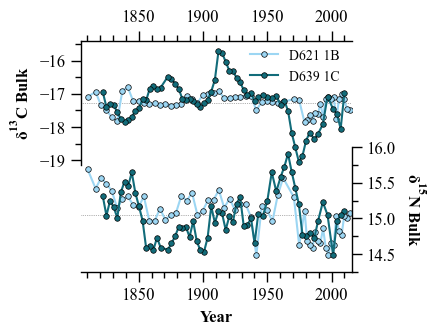

In [8]:
# Bulk Isotopes through time using trendvis

#turn off annoying matplotlib warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)    #gets rid of obnoxious warning that will come up otherwise

#initialize plot using trendvis
fig2 = tv.XGrid([6,6], xratios=[1], figsize=(half_width,3)) #XGrid indicates a shared x-axis (YGrid would flip orientation); first argument, ystack_ratios, refers to relative length of y-axes, starting with the top axis; second argument, xratios, would be useful if you had multiple columns/xaxes like with a hiatus, but its not really useful here; figsize refers to actual size of figure
fig2.cleanup_grid() #gets rid of redundant axes

#name axes so easier to call
ax1=fig2.axes[0][0] #d13C axis
ax2=fig2.axes[1][0] #d15N axis

# plot bulk isotope data
ax1.plot(bulk_D621_1B['Age Model'],bulk_D621_1B['d13C'], color='#9CD6F3',mec='k',linestyle='-',
         marker='o',markersize=4,mew=.5,label='D621 1B')
ax2.plot(bulk_D621_1B['Age Model'],bulk_D621_1B['d15N'], color='#9CD6F3',mec='k',linestyle='-',
         marker='o',markersize=4,mew=.5,label='D621 1B')
ax1.plot(bulk_D639_1C['Age Model'],bulk_D639_1C['d13C'], color='#126C7A',mec='k',linestyle='-',
         marker='o',markersize=4,mew=.5,label='D639 1C')
ax2.plot(bulk_D639_1C['Age Model'],bulk_D639_1C['d15N'], color='#126C7A',mec='k',linestyle='-',
         marker='o',markersize=4,mew=.5,label='D639 1C')

# plot means
ax1.axhline(bulk_data['d13C'].mean(),linestyle=':',lw=.5,color='dimgrey',zorder=-10)
ax2.axhline(bulk_data['d15N'].mean(),linestyle=':',lw=.5,color='dimgrey',zorder=-10)

#set axis limits
fig2.set_xlim([(0,1805,2016)])
fig2.set_ylim([(0,-19.15,-15.4), (1,14.25,16)])

#adjust tick marks
fig2.set_all_ticknums([(50,10)], #x axis ticks in first [], 
                      [(1,.5), (.5, .25)]) #y axis ticks in second [], listed from top to bottom
fig2.set_ticks(major_dim=(7, 2), labelsize=12,pad=4, minor_dim=(4, 2))

#axis properties and labels
fig2.set_spinewidth(1)
ax2.set_xlabel('Year', weight='semibold', color=(0,0,0,1), labelpad=5)
fig2.set_ylabels(['','','']) #tell it you want ylabels
ax1.set_ylabel('$\mathdefault{δ^{13}C}$ Bulk', weight='semibold', color=(0,0,0,1), rotation=90,labelpad=5)
ax2.set_ylabel('$\mathdefault{δ^{15}N}$ Bulk', weight='semibold', color=(0,0,0,1), rotation=270, labelpad=5)

#tick parameters
ax1.xaxis.set_tick_params(width=1,which='both')
ax2.xaxis.set_tick_params(width=1,which='both')
ax1.yaxis.set_tick_params(width=1,which='both')
ax2.yaxis.set_tick_params(width=1,which='both')

ax1.legend(facecolor=(1,1,1,1),loc='right',bbox_to_anchor=(1, .8),framealpha=0, fontsize=10).set_zorder(50)

#overlap axes and condense everything
fig2.fig.subplots_adjust(hspace=-.5)
fig2.cleanup_grid()

#save the figure
plt.savefig('figures/FIG2.pdf', dpi=1000,bbox_inches='tight')

plt.show()
plt.close()

## Figure 3 Comparing Sed Traps and Bamboo Coral Amino Acid Isotope Patterns

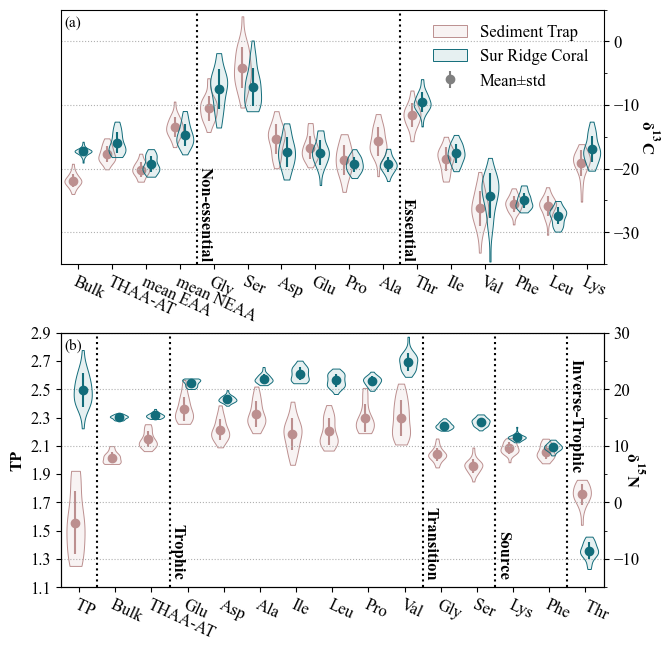

In [9]:
# AA pattern figure C and N violin plot

#set font size
plt.rcParams.update({'font.size': 12})

#select colors
sedcolor='#BC8F8F'
coralcolor='#126C7A'#'#126C7A'#'#79A6BD'#

#create violin plot function
def violin_custom(data, pos, axis, facecolor='c',z=0,label=None):
    violin=axis.violinplot(data,positions=pos,showmeans=False,showmedians=False,showextrema=False,widths=.5)
    for pc in violin['bodies']:
        pc.set_alpha(None)
        pc.set_facecolor(colors.to_rgba(facecolor, alpha=.1))
        pc.set_edgecolor(colors.to_rgba(facecolor, alpha=1))
        pc.set_linewidth(.7)
        pc.set_zorder(z)
        if pc==violin['bodies'][0]:
            pc.set_label(label)
    axis.errorbar(x=pos,y=data.mean(),yerr=data.std(),color=facecolor,linestyle='None',marker='o',zorder=z+1)
    return violin
    
#Figure illustrating values of various AAs in coral and sed trap samples
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(full_width,7.5))
fig.subplots_adjust(hspace=0.27)

#carbon part of plot

#create lists of variables of interest from sed trap and sur ridge coral datasets
AA_list_Shen=['Bulk','d13C THAA atomic','avg essential','avg nonessential','Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']
AA_list_SR=['d13C','d13C THAA atomic','avg essential','avg nonessential','Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']
label_list=['Bulk','THAA-AT','mean EAA','mean NEAA','Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']

#set horizontal spacing between sed trap and coral violin plots
offset=-.15

#make violin plots for sed trap and coral datasets
vals=np.arange(0,len(AA_list_SR),1)
violin_custom(sedtrap_d13C.loc[:,AA_list_Shen[1:]],pos=vals[1:]+offset,facecolor=sedcolor,axis=ax[0],z=-5,label='Sediment Trap')
violin_custom(sedtrap_d13C.loc[:,AA_list_Shen[0]].dropna(),pos=[vals[0]+offset],facecolor=sedcolor,axis=ax[0],z=-5) #plotted separately bc some bulk data are missing and contains nans
violin_custom(AA_d13C.loc[:,AA_list_SR],vals-offset,facecolor=coralcolor,axis=ax[0],z=5,label='Sur Ridge Coral')

#set other plot properties
ax[0].set_xticks(vals)
ax[0].set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')

ax[0].yaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(5))

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()

ax[0].set_ylabel('$\mathdefault{δ^{13}C}$',weight='bold',rotation=270,labelpad=15)

ax[0].set_xlim(-0.5,15.5)
ax[0].set_ylim(-35,5)

ax[0].grid(axis='y', linestyle=':',zorder=-5)

#annotations for essential vs nonessential AAs
ax[0].axvline(x=3.5, color='k',linestyle=':')
ax[0].axvline(x=9.5, color='k',linestyle=':')

ax[0].text(3.5, -34, 'Non-essential', weight='bold',rotation=270)
ax[0].text(9.5, -34, 'Essential', weight='bold',rotation=270)

#create legend
ax[0].errorbar(x=[-100],y=[-100],yerr=[1.5],color='gray',linestyle='None',marker='o',label='Mean±std') # for legend symbol
ax[0].legend(facecolor=None, loc='upper right', bbox_to_anchor=(1,1),frameon=False)

#nitrogen part of plot

#create lists of variables of interest from sed trap and sur ridge coral datasets
AA_list_Shen=['Bulk','d15N THAA atomic','Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']
AA_list_SR=['d15N','d15N THAA atomic', 'Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']
label_list=['TP ','Bulk ','THAA-AT', 'Glu', 'Asp', 'Ala','Ile','Leu','Pro','Val','Gly','Ser','Lys','Phe', ' Thr']

#set horizontal spacing between sed trap and coral violin plots
offset=-.1

#make violin plots for sed trap and coral datasets
ax2=ax[1].twinx() #create twinned axis to plot TP on
vals=np.arange(0,len(label_list),1)
violin_custom(sedtrap_d15N.loc[:,AA_list_Shen[0:]].dropna(),pos=vals[1:]+offset,facecolor=sedcolor,axis=ax[1],z=-5)
violin_custom(sedtrap_d15N.loc[:,'TP'].dropna(),pos=[vals[0]+offset],facecolor=sedcolor,axis=ax2,z=-5)

violin_custom(AA_d15N.loc[:,AA_list_SR],vals[1:]-offset,facecolor=coralcolor,axis=ax[1],z=5,label='Sur Ridge Coral')
violin_custom(AA_d15N.loc[:,'Coral TP'],pos=[vals[0]-offset],facecolor=coralcolor,axis=ax2,z=5)

#set other plot properties
ax[1].set_xticks(vals)
ax[1].set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')
ax[1].yaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(5))
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax2.set_yticks(np.arange(1.1,2.91,0.2))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax2.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax[1].set_ylabel('     $\mathdefault{δ^{15}N}$',weight='bold',rotation=270)
ax2.set_ylabel('TP',weight='bold',rotation=90)

ax[1].grid(axis='y', linestyle=':',zorder=-5)

ax[1].set_xlim(-0.5,14.5)
ax[1].set_ylim(-15,30)
ax2.set_ylim(1.1,2.9)

#add annotations separating trophic, source, inverse-trophic
ax[1].axvline(x=0.5, color='k',linestyle=':')
ax[1].axvline(x=2.5, color='k',linestyle=':')
ax[1].axvline(x=9.5, color='k',linestyle=':')
ax[1].axvline(x=11.5, color='k',linestyle=':')
ax[1].axvline(x=13.5, color='k',linestyle=':')

ax[1].text(2.5, -13, 'Trophic', weight='bold',rotation=270)
ax[1].text(9.5, -13, 'Transition', weight='bold',rotation=270)
ax[1].text(11.5, -13, 'Source', weight='bold',rotation=270)
ax[1].text(13.5, 6, 'Inverse-Trophic', weight='bold',rotation=270)

# add subplot labels
ax[0].text(-.4,4,'(a)',ha='left',va='top',fontsize=11,color='k')
ax[1].text(-.4,29,'(b)',ha='left',va='top',fontsize=11,color='k')

#save the figure
plt.savefig('figures/FIG3.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()


## Figure 4 Doherty et al. endmembers comparison

### Adjust d15N of individual AAs to account for polyp-skeleton and trophic offsets for plotting (including all AAs because some supplementary plots include all AAs)

In [10]:
# Correct d15N of individual AA for polyp-skeleton 
# offset in isidella after Mcmahon et al 2018 Table 1
AA_d15N['Glu_polyp']=AA_d15N['Glu']+3.4 # sd=0.5
AA_d15N['Asp_polyp']=AA_d15N['Asp']+3.8 # sd=0.6
AA_d15N['Ala_polyp']=AA_d15N['Ala']+3.8 # sd=0.7
AA_d15N['Ile_polyp']=AA_d15N['Ile']+3.6 # sd=0.4
AA_d15N['Leu_polyp']=AA_d15N['Leu']+3.8 # sd=0.7
AA_d15N['Pro_polyp']=AA_d15N['Pro+Hpro']+3.9 # sd=0.2
AA_d15N['Val_polyp']=AA_d15N['Val']+2.2 # sd=0.7
#correct Source AA for polyp-skeleton offset
AA_d15N['Gly_polyp']=AA_d15N['Gly']-1.3 # sd=0.3
AA_d15N['Ser_polyp']=AA_d15N['Ser']-0.7 # sd=0.3
AA_d15N['Phe_polyp']=AA_d15N['Phe']+.2 # sd=0.2
AA_d15N['Lys_polyp']=AA_d15N['Lys']-.3 # sd=0.4
#Correct Thr for polyp-skeleton offset
AA_d15N['Thr_polyp']=AA_d15N['Thr']-2.5 # sd=0.6

#Correct d15N AA for polyp-POM offset due to trophic transfer 
#(after TDfs for aquatic and marine ammonia-excreting species with TP<=3 
#from McMahon & McCarthy 2016 S1 excel sheet)
AA_d15N['Glu_POM']=AA_d15N['Glu_polyp']-8.3 #TDF=8.29, sd=3.2
AA_d15N['Asp_POM']=AA_d15N['Asp_polyp']-6.2 #TDF=6.24, sd=4.3
AA_d15N['Ala_POM']=AA_d15N['Ala_polyp']-6.9 #TDF=6.86, sd=3.5
AA_d15N['Leu_POM']=AA_d15N['Leu_polyp']-5.9 #TDF=5.92, sd=4.1
AA_d15N['Ile_POM']=AA_d15N['Ile_polyp']-6.5  #TDF=6.5, sd=4.5
AA_d15N['Pro_POM']=AA_d15N['Pro_polyp']-6.4 #TDF=6.36, sd=2.3
AA_d15N['Val_POM']=AA_d15N['Val_polyp']-4.5 #TDF=4.49, sd=2.8
AA_d15N['Gly_POM']=AA_d15N['Gly_polyp']-2.7 #TDF=2.74, sd=3.2
AA_d15N['Ser_POM']=AA_d15N['Ser_polyp']-3.5 #TDF=3.52, sd=4.6
AA_d15N['Phe_POM']=AA_d15N['Phe_polyp']-0.6 #TDF=0.58, sd=1.1
AA_d15N['Lys_POM']=AA_d15N['Lys_polyp']-1.7 #TDF=1.71, sd=2.0
AA_d15N['Thr_POM']=AA_d15N['Thr_polyp']+6.4  #TDF=6.4, sd=3.7

### make plot

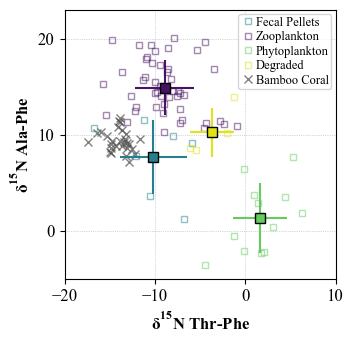

In [11]:
# compare coral data to Doherty et al, 2021 endmember dataset

#set font size
plt.rcParams.update({'font.size': 12})

#load in endmember data
Doherty_data=pd.read_csv('datasets/doherty_2021_endmember_data.csv')

#calculate mean and standard deviation for each end-member
mean_zoo_thrphe=Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_thr-phe'].mean()
std_zoo_thrphe=Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_thr-phe'].std()
mean_zoo_alaphe=Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_ala-phe'].mean()
std_zoo_alaphe=Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_ala-phe'].std()

mean_MD_thrphe=Doherty_data[Doherty_data['End-member']=='MD']['d15N_thr-phe'].mean()
std_MD_thrphe=Doherty_data[Doherty_data['End-member']=='MD']['d15N_thr-phe'].std()
mean_MD_alaphe=Doherty_data[Doherty_data['End-member']=='MD']['d15N_ala-phe'].mean()
std_MD_alaphe=Doherty_data[Doherty_data['End-member']=='MD']['d15N_ala-phe'].std()

mean_FP_thrphe=Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_thr-phe'].mean()
std_FP_thrphe=Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_thr-phe'].std()
mean_FP_alaphe=Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_ala-phe'].mean()
std_FP_alaphe=Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_ala-phe'].std()

mean_phyto_thrphe=Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_thr-phe'].mean()
std_phyto_thrphe=Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_thr-phe'].std()
mean_phyto_alaphe=Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_ala-phe'].mean()
std_phyto_alaphe=Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_ala-phe'].std()

#intialize plot
fig,ax=plt.subplots(figsize=(half_width,half_width))

#select colors
color_palette=sns.color_palette('viridis_r', 20)
fp_color=color_palette[11]
mic_color=color_palette[0]
zoo_color=color_palette[19]
phy_color=color_palette[4]

#plot endmember data
plt.plot(Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_thr-phe'],
         Doherty_data[Doherty_data['End-member']=='fecal pellets']['d15N_ala-phe'],
         linestyle='None',marker='s',color='None',mew=1,
         markersize=5,markeredgecolor=fp_color,alpha=.5,label='Fecal Pellets')
plt.plot(Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_thr-phe'],
         Doherty_data[Doherty_data['End-member']=='zooplankton']['d15N_ala-phe'],
         linestyle='None',marker='s',color='None',mew=1,
         markersize=5,markeredgecolor=zoo_color,alpha=.5,label='Zooplankton')
plt.plot(Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_thr-phe'],
         Doherty_data[Doherty_data['End-member']=='phytoplankton']['d15N_ala-phe'],
         linestyle='None',marker='s',color='None',mew=1,
         markersize=5,markeredgecolor=phy_color,alpha=.5,label='Phytoplankton')
plt.plot(Doherty_data[Doherty_data['End-member']=='MD']['d15N_thr-phe'],
         Doherty_data[Doherty_data['End-member']=='MD']['d15N_ala-phe'],
         linestyle='None',marker='s',color='None',mew=1,
         markersize=5,markeredgecolor=mic_color,alpha=.5,label='Degraded')

#plot endmember means and SDs
plt.errorbar(x=mean_zoo_thrphe,xerr=std_zoo_thrphe,y=mean_zoo_alaphe,yerr=std_zoo_alaphe,
             marker='s', linestyle='None',markeredgecolor='k',color=zoo_color,
             ecolor=zoo_color,barsabove=False,capsize=0, markersize=7,zorder=21)
plt.errorbar(x=mean_MD_thrphe,xerr=std_MD_thrphe,y=mean_MD_alaphe,yerr=std_MD_alaphe,
             marker='s', linestyle='None',markeredgecolor='k',color=mic_color,
             ecolor=mic_color,barsabove=False,capsize=0, markersize=7,zorder=21)
plt.errorbar(x=mean_FP_thrphe,xerr=std_FP_thrphe,y=mean_FP_alaphe,yerr=std_FP_alaphe,
             marker='s', linestyle='None',markeredgecolor='k',color=fp_color,
             ecolor=fp_color,barsabove=False,capsize=0, markersize=7,zorder=21)
plt.errorbar(x=mean_phyto_thrphe,xerr=std_phyto_thrphe,y=mean_phyto_alaphe,yerr=std_phyto_alaphe,
             marker='s', linestyle='None',markeredgecolor='k',color=phy_color,
             ecolor=phy_color,barsabove=False,capsize=0, markersize=7,zorder=21)

#plot corrected Sur Ridge coral data
plt.plot(AA_d15N['Thr_POM']-AA_d15N['Phe_POM'],
         AA_d15N['Ala_POM']-AA_d15N['Phe_POM'],
         linestyle='None',marker='x',color='None',
         markeredgecolor=(.3,.3,.3,1),mew=1,alpha=.7,
         label='Bamboo Coral',
         ms=6,zorder=-10)

#plot settings
ax.set_xlim(-20,10)
ax.set_ylim(-5,23)
ax.set_xlabel('$\mathdefault{δ^{15}N}$ Thr-Phe',weight='semibold')
ax.set_ylabel('$\mathdefault{δ^{15}N}$ Ala-Phe',weight='semibold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(b=True,axis='both', linestyle=':',lw=.5)
ax.yaxis.set_major_locator(MultipleLocator(10))

#add legend
plt.legend(facecolor='w',ncol=1,fontsize=9,handlelength=1.2,labelspacing=.2,
           title_fontsize=9,handletextpad=0,borderpad=0.2, borderaxespad=1,
           loc='upper right',bbox_to_anchor=(1.03,1.03)).set_zorder(30)

#save figure
plt.savefig('figures/FIG4.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

#AA_d15N.to_csv(r'C:\Users\gmpug\Documents\UCSC stuff\Phytoplankton Culturing Project\R_scripts\AA_d15N_all.csv',index=False)

## Figure 5 Bulk vs AA Variables

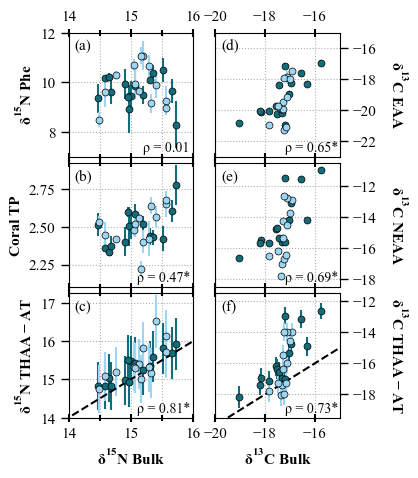

In [12]:
#%% biplots for bulk vs CSI-AA data

#set plot properties
matplotlib.rc('font', size=11)
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.minor.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 4

#initialize plot
fig,ax=plt.subplots(3,2,figsize=(half_width,5),sharex='col')

#set up spacing between subplots
fig.subplots_adjust(hspace=0.05, wspace=0.18)

#N biplots
ax[0,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D639_1C']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Phe'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D639_1C']['Phe_std'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[0,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D621_1B']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Phe'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D621_1B']['Phe_std'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')
ax[1,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D639_1C']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Coral TP'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D639_1C']['Coral TP'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[1,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D621_1B']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Coral TP'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D621_1B']['Coral TP'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')
ax[2,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D639_1C']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D639_1C']['d15N THAA atomic'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D639_1C']['d15N THAA atomic'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[2,0].errorbar(AA_d15N[AA_d15N['Coral ID']=='D621_1B']['d15N'],
                 AA_d15N[AA_d15N['Coral ID']=='D621_1B']['d15N THAA atomic'],
                 yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D621_1B']['d15N THAA atomic'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')

#C biplots

ax[0,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D639_1C']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D639_1C']['avg essential'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D639_1C']['avg essential'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[0,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D621_1B']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D621_1B']['avg essential'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D621_1B']['avg essential'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')
ax[1,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D639_1C']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D639_1C']['avg nonessential'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D639_1C']['avg nonessential'],
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[1,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D621_1B']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D621_1B']['avg nonessential'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D621_1B']['avg nonessential'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')
ax[2,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D639_1C']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D639_1C']['d13C THAA atomic'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D639_1C']['d13C THAA atomic'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#126C7A',markeredgecolor='k',ecolor='#126C7A', capsize=0, label='D639 #1C')
ax[2,1].errorbar(AA_d13C[AA_d13C['Coral ID']=='D621_1B']['d13C'],
                 AA_d13C[AA_d13C['Coral ID']=='D621_1B']['d13C THAA atomic'],
                 yerr=AA_d13Cstd[AA_d13Cstd['Coral ID']=='D621_1B']['d13C THAA atomic'], 
                 marker='o',markersize=5,markeredgewidth=.5,linestyle='None',
                 color='#9CD6F3',markeredgecolor='k',ecolor='#9CD6F3', capsize=0, label='D621 #1B')

#1:1 lines for THAA
x_C=np.arange(-21,-10,1)
ax[2,1].plot(x_C,x_C,color='k',linestyle='--')
#ax[0,1].plot(x_C+20,x_C+20,color='k',linestyle='--', label='1:1 line')
x_N=np.arange(13,17,1)
ax[2,0].plot(x_N,x_N,color='k',linestyle='--')

#set axis labels
ax[0,0].set_ylabel('$\mathdefault{δ^{15}N}$ Phe',weight='semibold')
ax[1,0].set_ylabel('Coral TP',weight='semibold')
ax[2,0].set_ylabel('$\mathdefault{δ^{15}N}$'+' '+'$\mathdefault{THAA-AT}$',weight='semibold')
ax[0,1].set_ylabel('$\mathdefault{δ^{13}C}$ EAA', rotation=270,labelpad=23,weight='semibold')
ax[1,1].set_ylabel('$\mathdefault{δ^{13}C}$ NEAA', rotation=270,labelpad=23,weight='semibold')
ax[2,1].set_ylabel('$\mathdefault{δ^{13}C}$ '+'$\mathdefault{THAA-AT}$', rotation=270,labelpad=23,weight='semibold')


ax[0,1].xaxis.set_label_position('top') 
ax[0,0].xaxis.set_label_position('top') 

ax[2,1].set_xlabel('$\mathdefault{δ^{13}C}$ Bulk',labelpad=5,weight='semibold')
ax[2,0].set_xlabel('$\mathdefault{δ^{15}N}$ Bulk',labelpad=5,weight='semibold')

#set tick frequency
for i in [0,1,2]:
        ax[i,0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax[i,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

for i in [0,1,2]:
        ax[i,1].yaxis.set_major_locator(ticker.MultipleLocator(2.0))
        ax[i,1].xaxis.set_major_locator(ticker.MultipleLocator(2.0))

#x axis tick labal format
ax[0,0].xaxis.set_major_formatter(FormatStrFormatter('%g'))

#tick properties
ax[0,1].tick_params(axis='x',which='both',direction='inout',top=True,bottom=True, width=1.5,labeltop='on')
ax[0,0].tick_params(axis='x',which='both',direction='inout',top=True,bottom=True,zorder=20,width=1.5,labeltop='on')
ax[1,0].tick_params(axis='x',which='both',direction='inout',top=True, bottom=True,zorder=20,width=1.5)
ax[1,1].tick_params(axis='x',which='both',direction='inout',top=True, bottom=True,zorder=20,width=1.5)
ax[2,0].tick_params(axis='x',which='both',direction='inout',top=True, bottom=True,zorder=20,width=1.5)
ax[2,1].tick_params(axis='x',which='both',direction='inout',top=True, bottom=True,zorder=20,width=1.5)

for i in [0,1,2]:
    ax[i,1].yaxis.set_label_position("right")
    ax[i,1].yaxis.tick_right()

#grid properties
for i in [0,1,2]:
    for j in [0,1]:
        ax[i,j].grid(axis='x', which='both',linestyle=':')
        ax[i,j].grid(axis='y', which='both',linestyle=':')

#axis limits
ax[0,0].set_xlim(14,16)
ax[0,1].set_xlim(-20,-15)

ax[0,0].set_ylim(7,12)
ax[0,1].set_ylim(-23,-15)
ax[1,0].set_ylim(2.1,2.92)
ax[1,1].set_ylim(-18.5,-10.5)
ax[2,0].set_ylim(14,17.25)
ax[2,1].set_ylim(-19.5,-11.5)

#add spearman's rho
ax[0,0].text(15.95,7.1,'ρ = 0.01',ha='right',va='bottom',fontsize=10)
ax[0,1].text(-15.05,-22.85,'ρ = 0.65*',ha='right',va='bottom',fontsize=10)
ax[1,0].text(15.95,2.115,'ρ = 0.47*',ha='right',va='bottom',fontsize=10)
ax[1,1].text(-15.05,-18.3,'ρ = 0.69*',ha='right',va='bottom',fontsize=10)
ax[2,0].text(15.95,14.05,'ρ = 0.81*',ha='right',va='bottom',fontsize=10)
ax[2,1].text(-15.05,-19.4,'ρ = 0.73*',ha='right',va='bottom',fontsize=10)

#add subplot labels
ax[0,0].text(0.05,.95,'(a)',ha='left',va='top',fontsize=11,color='k',transform=ax[0,0].transAxes)
ax[1,0].text(0.05,.95,'(b)',ha='left',va='top',fontsize=11,color='k',transform=ax[1,0].transAxes)
ax[2,0].text(0.05,.95,'(c)',ha='left',va='top',fontsize=11,color='k',transform=ax[2,0].transAxes)
ax[0,1].text(0.05,.95,'(d)',ha='left',va='top',fontsize=11,color='k',transform=ax[0,1].transAxes)
ax[1,1].text(0.05,.95,'(e)',ha='left',va='top',fontsize=11,color='k',transform=ax[1,1].transAxes)
ax[2,1].text(0.05,.95,'(f)',ha='left',va='top',fontsize=11,color='k',transform=ax[2,1].transAxes)

#save and close figure
plt.savefig('figures/FIG5.pdf', dpi=1000,bbox_inches='tight')

plt.show()
plt.close()

## Fig 6 Time Series Bulk and CSI-AA Isotope Variables

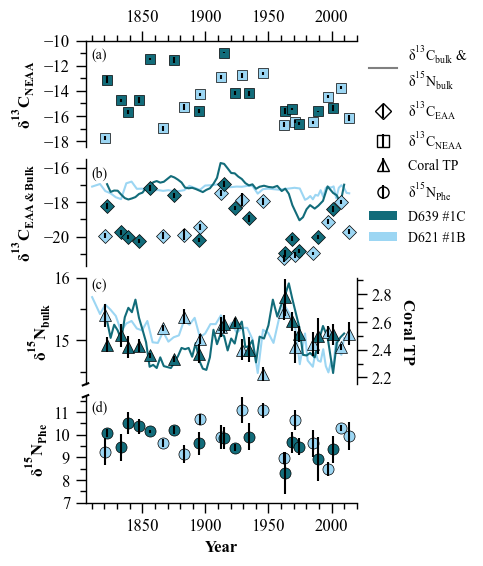

In [13]:
#%% Plot isotope variables vs time using trendvis

#silence annoying matplotlib warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)    #gets rid of obnoxious warning that will come up otherwise

#set font size
plt.rcParams.update({'font.size': 12})

#initialize trendvis plot
fig6 = tv.XGrid([5,5,5,5], xratios=[1], figsize=(half_width,6)) #XGrid indicates a shared x-axis (YGrid would flip orientation); first argument, ystack_ratios, refers to relative length of y-axes, starting with the top axis; second argument, xratios, would be useful if you had multiple columns/xaxes like with a hiatus, but its not really useful here; figsize refers to actual size of figure
fig6.make_twins([2]) #make two twinned axes
fig6.cleanup_grid() #gets rid of redundant axes

#name axes so easier to call
ax_d13C=fig6.axes[0][0] #d13C EAA and bulk
ax_d13C2=fig6.axes[1][0] #d13C EAA and bulk
ax_phe=fig6.axes[3][0] #d15N phe
ax_TP=fig6.axes[4][0] #TP
ax_d15N=fig6.axes[2][0] #d15N

#plot d13C bulk data
ax_d13C2.plot(bulk_D621_1B['Age Model'],bulk_D621_1B['d13C'],
         color='#9CD6F3',linestyle='-',label='D621 1B',zorder=-10)
ax_d13C2.plot(bulk_D639_1C['Age Model'],bulk_D639_1C['d13C'], 
         color='#126C7A',linestyle='-',label='D639 1C',zorder=-10)

#plot nonessential aa d13C
ax_d13C.errorbar(x=AA_d13C[AA_d13C['Coral ID']=='D621_1B']['Age Model'],
         y=AA_d13C[AA_d13C['Coral ID']=='D621_1B']['avg nonessential'],
         yerr=AA_d13Cstd[AA_d13C['Coral ID']=='D621_1B']['avg nonessential'],
         marker='s', linestyle='None',color='#9CD6F3', markeredgecolor='k',
         ecolor='k',barsabove=True,capsize=0, markersize=7,mew=.5)
ax_d13C.errorbar(x=AA_d13C[AA_d13C['Coral ID']=='D639_1C']['Age Model'],
         y=AA_d13C[AA_d13C['Coral ID']=='D639_1C']['avg nonessential'],
         yerr=AA_d13Cstd[AA_d13C['Coral ID']=='D639_1C']['avg nonessential'],
         marker='s', linestyle='None',color='#126C7A', markeredgecolor='k',
         ecolor='k',barsabove=True,capsize=0, markersize=7,mew=.5)

#plot essential aa d13C
ax_d13C2.errorbar(x=AA_d13C[AA_d13C['Coral ID']=='D621_1B']['Age Model'],
             y=AA_d13C[AA_d13C['Coral ID']=='D621_1B']['avg essential'],
             yerr=AA_d13Cstd[AA_d13C['Coral ID']=='D621_1B']['avg essential'],
             marker='D', linestyle='None',color='#9CD6F3', markeredgecolor='k',
             ecolor='k',barsabove=True,capsize=0, markersize=7,mew=.5)#, label='D621 1B')
ax_d13C2.errorbar(x=AA_d13C[AA_d13C['Coral ID']=='D639_1C']['Age Model'],
             y=AA_d13C[AA_d13C['Coral ID']=='D639_1C']['avg essential'],
             yerr=AA_d13Cstd[AA_d13C['Coral ID']=='D639_1C']['avg essential'],
             marker='D', linestyle='None',color='#126C7A', markeredgecolor='k',
             ecolor='k',barsabove=True,capsize=0, markersize=7,mew=.5)#, label='D639 1C')
#plot d15N bulk data
ax_d15N.plot(bulk_D621_1B['Age Model'],bulk_D621_1B['d15N'], 
         color='#9CD6F3',linestyle='-',label='D621 1B')
ax_d15N.plot(bulk_D639_1C['Age Model'],bulk_D639_1C['d15N'],
         color='#126C7A',linestyle='-',label='D639 1C')

# plot coral TP
ax_TP.errorbar(x=AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Age Model'],
             y=AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Coral TP'], 
             yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D621_1B']['Coral TP'],
             marker='^', linestyle='None',color='#9CD6F3', markeredgecolor='k',
             ecolor='k',barsabove=True,capsize=0, markersize=8,mew=.5)
ax_TP.errorbar(x=AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Age Model'],
             y=AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Coral TP'], 
             yerr=AA_d15Nstd[AA_d15Nstd['Coral ID']=='D639_1C']['Coral TP'],
             marker='^', linestyle='None',color='#126C7A', markeredgecolor='k',
             ecolor='k',barsabove=True,capsize=0, markersize=8,mew=.5)

#plot Phe d15N
ax_phe.errorbar(x=AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Age Model'],
         y=AA_d15N[AA_d15N['Coral ID']=='D621_1B']['Phe'],
         yerr=AA_d15Nstd[AA_d13C['Coral ID']=='D621_1B']['Phe_std'],
         marker='o', linestyle='None',color='#9CD6F3', markeredgecolor='k',
         ecolor='k',barsabove=True,capsize=0, markersize=8,mew=.5)
ax_phe.errorbar(x=AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Age Model'],
         y=AA_d15N[AA_d15N['Coral ID']=='D639_1C']['Phe'],
         yerr=AA_d15Nstd[AA_d15N['Coral ID']=='D639_1C']['Phe_std'],
         marker='o', linestyle='None',color='#126C7A', markeredgecolor='k',
         ecolor='k',barsabove=True,capsize=0, markersize=8,mew=.5)

#set axis limits
fig6.set_xlim([(0,1805,2020)])
#fig6.set_ylim([(0,-21,-15), (2,14.3,16),(1, 2.15,2.9)]) #if are doing for twins, start counting twins from top after counting all original axes 
ax_d13C.set_ylim(-18.5,-10)
ax_d13C2.set_ylim(-21.7,-15.5)
ax_d15N.set_ylim(14.3,16)
ax_TP.set_ylim(2.15,2.92)
ax_phe.set_ylim(7, 11.7) 

#move TP axis in front of bulk d15N axis 
ax_TP.set_zorder(ax_d15N.get_zorder()+1)

#adjust tick marks and spines
fig6.set_all_ticknums([(50,10)], #x axis ticks in first [], 
                      [(2,1),(2,1),(1,.5),(1,.5),(.2,.1)]) #y axis ticks in second [], listed from top to bottom
fig6.set_ticks(major_dim=(7, 2), labelsize=12, pad=4, minor_dim=(4, 2))

ax_TP.xaxis.set_tick_params(labeltop=False,labelbottom=False)
ax_d13C2.xaxis.set_tick_params(labeltop=False,labelbottom=False)
ax_d13C.xaxis.set_tick_params(labelbottom=False)
ax_d15N.xaxis.set_tick_params(labeltop=False,labelbottom=False)

for axis in [ax_phe,ax_d13C2]:
    axis.spines['right'].set_position(('axes',0))
    axis.yaxis.set_label_position("left")
    axis.yaxis.tick_left()

fig6.set_spinewidth(1)
for axis in [ax_TP,ax_d13C2,ax_d13C,ax_phe,ax_d15N]:
    axis.xaxis.set_tick_params(width=1,which='both')
    axis.yaxis.set_tick_params(width=1,which='both')

# set axis labels
ax_phe.set_xlabel('Year', weight='semibold', color=(0,0,0,1), labelpad=5)
fig6.set_ylabels(['','','','','']) #tell trendvis you want ylabels
ax_d13C.set_ylabel('$\mathdefault{δ^{13}C_{NEAA}}$', weight='semibold', color=(0,0,0,1), rotation=90, ha='center',labelpad=5)
ax_d13C2.set_ylabel('$\mathdefault{δ^{13}C_{EAA\,&\,Bulk}}$', weight='semibold', color=(0,0,0,1), rotation=90, ha='center',labelpad=-35)
ax_d15N.set_ylabel('$\mathdefault{δ^{15}N_{bulk}}$', weight='semibold', color=(0,0,0,1), rotation=90, va='top',ha='center', labelpad=20)
ax_TP.set_ylabel('Coral TP', weight='semibold', color=(0,0,0,1), rotation=270, va='top',ha='center',labelpad=15)
ax_phe.set_ylabel('$\mathdefault{δ^{15}N_{Phe}}$', weight='semibold', color=(0,0,0,1), rotation=90, va='top',ha='center',labelpad=-45)

#set up axis break between d15N bulk and phe axes
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs=dict(transform=ax_d15N.transAxes, color='k', clip_on=False)
ax_d15N.plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=ax_phe.transAxes)  # switch to the bottom axes
ax_phe.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

#made up plots outside of axis limits for legend symbols
ax_d13C.plot([2100,2101],[20,20],color='gray',label='$\mathdefault{δ^{13}C_{bulk}}$'+' &\n$\mathdefault{δ^{15}N_{bulk}}$')
ax_d13C.errorbar(x=[2100],y=[20],yerr=[0.1],marker='D',color='None',mec='k',ecolor='k',markersize=8,
                 barsabove=True,linestyle='None',label='$\mathdefault{δ^{13}C_{EAA}}$')
ax_d13C.errorbar(x=[2100],y=[20],yerr=[0.1],marker='s',color='None',mec='k',ecolor='k',markersize=8,
                 barsabove=True,linestyle='None',label='$\mathdefault{δ^{13}C_{NEAA}}$')
ax_d13C.errorbar(x=[2100],y=[20],yerr=[0.1],marker='^',color='None',mec='k',ecolor='k',markersize=8,
                 barsabove=True,linestyle='None',label='Coral TP')
ax_d13C.errorbar(x=[2100],y=[20],yerr=[0.1],marker='o',color='None',mec='k',ecolor='k',markersize=8,
                 barsabove=True,linestyle='None',label='$\mathdefault{δ^{15}N_{Phe}}$')
ax_d13C.bar(2100,20,color='#126C7A',width=1.2,label='D639 #1C')
ax_d13C.bar(2100,20,color='#9CD6F3',width=1.2,label='D621 #1B')

#add legend
ax_d13C.legend(facecolor=(1,1,1,0),loc='upper left',bbox_to_anchor=(1, 1.1),framealpha=0, fontsize=10)

# subplot labels
ax_d13C.text(1810,-10.5,'(a)',ha='left',va='top',fontsize=10,color='k')
ax_d13C2.text(1810,-15.9,'(b)',ha='left',va='top',fontsize=10,color='k')
ax_d15N.text(1810,16,'(c)',ha='left',va='top',fontsize=10,color='k')
ax_phe.text(1810,11.5,'(d)',ha='left',va='top',fontsize=10,color='k')

#set vertical axis spacing
fig6.fig.subplots_adjust(hspace=1)
fig6.cleanup_grid()

#save and close figure
plt.savefig('figures/FIG6.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

## Figure 7 Correlation Analysis

### Note: will take a long time to run (~10 mins) with nsim=10,000 set as the number of simulations used for p-value estimation, as used in the manuscript. Here it has been changed to nsim=1,000 to speed up run time, but to replicate the results from the paper exactly, change to nsim=10,000 on line 19 of the cell titled "Create Correlation Matrix"

### first merge csi-aa variables of interest, bulk isotopes and climate variables (PDO and SST) into one dataframe

In [14]:
# Create merged/joined dataframe for correlation analysis

#make merged climate dataframe (PDO and SST)
SST_df=SST_upseason[['date','SST_upseason_3yr_movavg',
                     'SST_upseason_3yr_movavg_detrend']].merge(
       SST_annual[['date','SST_annual_3yr_movavg',
                   'SST_annual_3yr_movavg_detrend']],
                    how='outer', left_on=['date'], right_on=['date'])
climate_df=PDO_annual[['date','PDO_annual_3yr_movavg']].merge(SST_df,how='outer', left_on=['date'], right_on=['date'])
climate_df = climate_df.loc[(climate_df['date'] >= '1899-1-1') & (climate_df['date'] <= '2014-12-31')]
climate_df['Year']=climate_df['date'].dt.year+.5

#create merged bulk and climate variable dataframe
#bulk is treated separately here to retain high res 
#bulk data in the correlation analysis with climate
#instead of just bulk data from samples that also have csi-aa
bulk_tomerge=bulk_data.rename(columns={"Age Model": "Year"})
bulk_climate_df=pd.merge_asof(bulk_tomerge[['Year','d13C','d15N']],climate_df, on="Year", direction='nearest',tolerance=1)

#make merged csi-aa dataframe (both carbon and nitrogen)
csiaa_df=AA_d13C[['Age Model','avg essential','avg nonessential','d13C THAA atomic']].merge(
      AA_d15N[['Age Model','Coral TP','Phe','d15N THAA atomic']],
      how='outer', left_on=['Age Model'], right_on=['Age Model'])
csiaa_df.rename(columns={"Age Model": "Year",'Phe':'d15N Phe'},inplace=True)

#merge csi-aa onto bulk and climate dataframe
corr_df=bulk_climate_df.merge(csiaa_df,how='outer', left_on=['Year'], right_on=['Year'])

### create functions to help with calculating spearman's rho and p-values

In [15]:
# define a function to calculate correlations with the p-value adjusted for autocorrelation
def spearman_pval_adjusted(y1,y2,timevar,nsim=1000):
    #load data into pandas dataframe
    df=pd.DataFrame({'y1':y1,'y2':y2,'time':timevar})
    
    #replace filler values (999) with Nans and drop nans 
    df.replace(999, np.NaN,inplace=True)
    df.dropna(inplace=True)

    #select vars of interest
    y1_vals,y2_vals,time_vals=df['y1'].values,df['y2'].values,df['time'].values

    #estimate lag-1 autocorrelation coefficients 
    #of each timeseries by interpolating to obtain even spacing
    #then finding lag-1 ac coefficient of interpolated series
    step_width=(max(time_vals)-min(time_vals))/len(time_vals) #interpolation step width is same mean resolution as orig series
    y1_interp_time,y1_interp=tsutils.interp(time_vals, y1_vals, interp_type='nearest', step=step_width) #interpolation
    y2_interp_time,y2_interp=tsutils.interp(time_vals, y2_vals, interp_type='nearest', step=step_width)
    y1_lag1ac=smt.acf(y1_interp,nlags=1,fft=False)[1] #calculate lag-1 autocorrelation coefficient
    y2_lag1ac=smt.acf(y2_interp,nlags=1,fft=False)[1]
    
    #calculate spearman's rho coefficient
    rho=scipy.stats.spearmanr(y1_vals,y2_vals)[0] #

    #simulate n=nsim AR(1) process timeseries with same AC coefficient as 
    #the two timeseries of interest. Then find p-value based on probability 
    #distribution of spearman correlations of those randomly generated series
    ar_y1 = np.r_[1, -y1_lag1ac]  # AR model parameter 
    ar_y2 = np.r_[1, -y2_lag1ac]  # AR model parameter
    ma = np.r_[1, 0.0] # MA model parameters
    spearman_sims=np.empty(shape=(nsim))
    for i in range(0,nsim-1):
        #generate AR(1) processes with same lag-1 ac as timeseries of interest
        sim_y1=smt.arma_generate_sample(ar_y1, ma, nsample=len(y1_vals), scale=np.std(y1_vals),burnin=50)
        sim_y2=smt.arma_generate_sample(ar_y2, ma, nsample=len(y2_vals), scale=np.std(y2_vals),burnin=50)
        #calculate spearman's rho between those two randomly generated series
        spearman_sims[i]=abs(scipy.stats.spearmanr(sim_y1, sim_y2)[0])
    #find p-values based on probability distribution of simulated spearman coefficients
    pval=1-(scipy.stats.percentileofscore(spearman_sims, abs(rho))/100)
    return rho, pval

#normal way of calculating, no adjustment for autocorrelation
def spearman_rho(y1,y2,timevar): 
    #load data into pandas dataframe, replace filler values with Nans and drop nans 
    df=pd.DataFrame({'y1':y1,'y2':y2,'time':timevar})
    df.replace(999, np.NaN,inplace=True)
    df.dropna(inplace=True)

    #select variables
    y1_vals,y2_vals,time_vals=df['y1'].values,df['y2'].values,df['time'].values
    
    #calculate spearman's rho coefficient
    rho=scipy.stats.spearmanr(y1_vals,y2_vals)[0]
    
    return rho

### Create Correlation Matrix

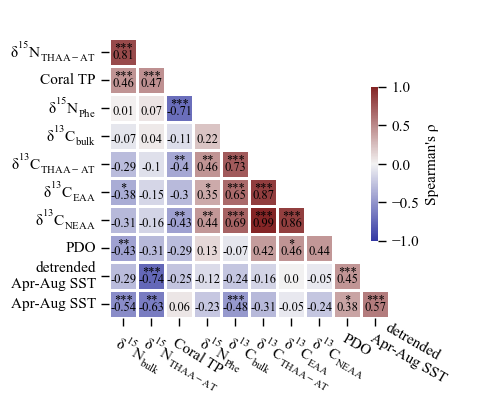

In [23]:
#create correlation map for AA and climate data (all dates)

#select time variable
time=corr_df['Year']

#set order of variables for plot
cols=['d15N','d15N THAA atomic','Coral TP','d15N Phe',
      'd13C','d13C THAA atomic','avg essential','avg nonessential',
      'PDO_annual_3yr_movavg','SST_upseason_3yr_movavg_detrend','SST_upseason_3yr_movavg']
correlation_df = corr_df.loc[:,cols]

#fill na values with specific value so it's easy to drop
correlation_df.fillna(999,inplace=True)

#calculate correlation coefficient matrix (using simpler spearman's rho method, it's faster)
corr=correlation_df.corr(method=lambda x, y: spearman_rho(y1=x, y2=y,timevar=time))

#calculate p-value matrix using spearman method adjusted for autocorrelation
nsim=10000 #set number of simulations to use to estimate p-values
pval = correlation_df.corr(method=lambda x, y: spearman_pval_adjusted(y1=x, y2=y,timevar=time,nsim=nsim)[1]) - np.eye(*corr.shape)
p = pval.map(lambda x: ''.join(['*' for t in [0.105,0.055,0.015] if x<t]))

# Set up the matplotlib plot configuration
font = {'size'   : 11}
matplotlib.rc('font', **font)

#initialize plot
fig, ax = plt.subplots(figsize=(4,4))

# Generate a mask for upper part of figure
mask = np.triu(np.ones_like(corr, dtype=bool),k=0)

#set colormap
cmap=sns.diverging_palette(265, 12, s=70, l=30, as_cmap=True)

# Draw the heatmap
labels=p+'\n'+corr.round(2).astype(str)
sns.heatmap(round(corr,2), annot=labels, fmt='',center=0, vmin=-1,vmax=1,mask = mask, 
            cmap=cmap, square=True, linewidths=1,
            cbar_kws = {'shrink': .5,'ticks' : [-1, -.5, 0, 0.5, 1], 
                        'pad':-.15,'label':"Spearman's ρ"},
            annot_kws={'fontsize': 9,'color':'k', 'alpha': 1,'va':'center','linespacing':.5})

#tick parameters
yticks = ax.yaxis.get_major_ticks()
yticks[0].set_visible(False)
xticks = ax.xaxis.get_major_ticks()
xticks[-1].set_visible(False)
plt.xticks(rotation = -30,ha='left',rotation_mode='anchor')

#set formatted tick labels
ax.yaxis.set_ticklabels(['$\mathdefault{δ^{15}N_{bulk}}$','$\mathdefault{δ^{15}N_{THAA-AT}}$',
                         'Coral TP'                       ,'$\mathdefault{δ^{15}N_{Phe}}$',
                         '$\mathdefault{δ^{13}C_{bulk}}$','$\mathdefault{δ^{13}C_{THAA-AT}}$',
                         '$\mathdefault{δ^{13}C_{EAA}}$' ,'$\mathdefault{δ^{13}C_{NEAA}}$',
                          'PDO','detrended\nApr-Aug SST','Apr-Aug SST'])
ax.xaxis.set_ticklabels(['$\mathdefault{δ^{15}N_{bulk}}$' ,'$\mathdefault{δ^{15}N_{THAA-AT}}$',
                         ''                               ,'$\mathdefault{δ^{15}N_{Phe}}$',
                         '$\mathdefault{δ^{13}C_{bulk}}$' ,'$\mathdefault{δ^{13}C_{THAA-AT}}$',
                         '$\mathdefault{δ^{13}C_{EAA}}$'  ,'$\mathdefault{δ^{13}C_{NEAA}}$',
                          'PDO','Apr-Aug SST','Apr-Aug SST'])
ax.text(9.8, 12.5, 'detrended', fontsize=11,rotation=-30) #manual formatting some tick labels that look odd otherwise
ax.text(2.2, 13, 'Coral TP', fontsize=11,rotation=-32)

#save the figure
plt.savefig('figures/FIG7.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

## Figure 8 Timeseries of Isotopes and Climate Variables Together

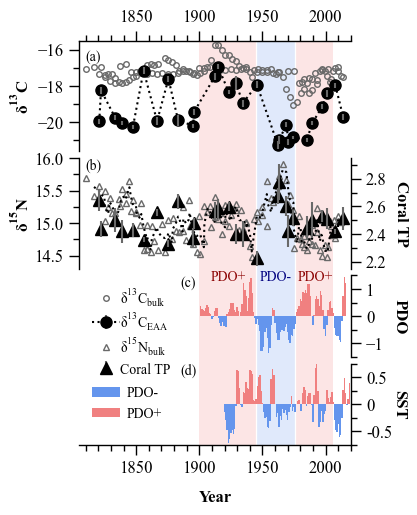

In [17]:
#suppress annoying matplotlib warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)    #gets rid of obnoxious warning that will come up otherwise

#fontsize
plt.rcParams.update({'font.size': 12})

#initialize plot
fig8 = tv.XGrid([4,4,3,3], xratios=[1], figsize=(half_width,half_width*6/4)) #XGrid indicates a shared x-axis (YGrid would flip orientation); first argument, ystack_ratios, refers to relative length of y-axes, starting with the top axis; second argument, xratios, would be useful if you had multiple columns/xaxes like with a hiatus, but its not really useful here; figsize refers to actual size of figure
fig8.make_twins([1])
fig8.cleanup_grid() #gets rid of redundant axes

#label axes to make it easier to call them
bulkC_ax=fig8.axes[0][0] #upper left axis
bulkN_ax=fig8.axes[4][0] #middle left axis
TP_ax=fig8.axes[1][0] #middle right axis
PDO_ax=fig8.axes[2][0] #upper right axis
SST_ax=fig8.axes[3][0] 

#plot Coral TP
TP_ax.errorbar(x=AA_d15N['Age Model'],
             y=AA_d15N['Coral TP'], 
             yerr=AA_d15Nstd['Coral TP'],
             marker='^', linestyle='None',color='k', markeredgecolor='k',
             ecolor='dimgrey',barsabove=True,capsize=0, markersize=8,zorder=100,label='Coral TP')

# plot mean essential d13C
bulkC_ax.errorbar(x=AA_d13C['Age Model'],
             y=AA_d13C['avg essential'],
             yerr=AA_d13Cstd['avg essential'],
             marker='o', linestyle=':',color='k', markeredgecolor='k',
             ecolor='dimgrey',barsabove=True,capsize=0, markersize=8, label='$\mathdefault{δ^{13}C_{EAA}}$')

#plot bulk d13C
bulkC_ax.plot(bulk_data['Age Model'],bulk_data['d13C'],
              color='None',mec='dimgrey',linestyle='None',marker='o',markersize=4,zorder=-100,
              label='$\mathdefault{δ^{13}C_{bulk}}$')

#plot bulk d15N
bulkN_ax.plot(bulk_data['Age Model'],bulk_data['d15N'], 
              color='None',mec='dimgrey',linestyle='None',marker='^',markersize=4,zorder=-100,
              label='$\mathdefault{δ^{15}N_{bulk}}$')
bulkN_ax.plot(bulk_data['Age Model'],bulk_data['d15N'].rolling(window=2,min_periods=2,center=True).mean(), 
         color='k',linestyle=':',marker='None',markersize=2)

#plot PDO
color = ['cornflowerblue' if y<0 else 'lightcoral' for y in np.asarray(PDO_annual['PDO_annual_3yr_movavg'])]
PDO_ax.bar(PDO_annual['Year'],PDO_annual['PDO_annual_3yr_movavg'],color=color,width=1.2)

# Plot SST
color = ['cornflowerblue' if y<0 else 'lightcoral' for y in SST_upseason['SST_upseason_3yr_movavg_detrend']]
SST_ax.bar(SST_upseason['year'],SST_upseason['SST_upseason_3yr_movavg_detrend'],color=color,width=1.2)

#Fake symbols outside axis limits for legend
PDO_ax.bar(2100,scipy.stats.zscore(PDO_annual['PDO_annual_3yr_movavg'])[10],color=color[0],width=1.2,label='PDO-')
PDO_ax.bar(2100,scipy.stats.zscore(PDO_annual['PDO_annual_3yr_movavg'])[0],color=color[10],width=1.2,label='PDO+')

#shaded areas for PDO annotation
fig8.draw_bar(SST_ax, fig8.axes[0][0], (1900,1945), alpha=.2, edgecolor='none', facecolor='lightcoral')
fig8.draw_bar(SST_ax, fig8.axes[0][0], (1946,1976), alpha=.2, edgecolor='none', facecolor='cornflowerblue')
fig8.draw_bar(SST_ax, fig8.axes[0][0], (1977,2006), alpha=.2, edgecolor='none', facecolor='lightcoral')

fig8.draw_bar(SST_ax, fig8.axes[0][0], (1976,1977), alpha=1, edgecolor='w', facecolor=(1,1,1,0),lw=.2)
fig8.draw_bar(SST_ax, fig8.axes[0][0], (1945,1946), alpha=1, edgecolor='w', facecolor=(1,1,1,0),lw=.2)

#annotate shaded areas
PDO_ax.text(1923,1.2,'PDO+',ha='center',va='bottom',fontsize=10,color='darkred')
PDO_ax.text(1961,1.2,'PDO-',ha='center',va='bottom',fontsize=10,color='navy')
PDO_ax.text(1992,1.2,'PDO+',ha='center',va='bottom',fontsize=10,color='darkred')

#subplot labels
bulkC_ax.text(1810,-16,'(a)',ha='left',va='top',fontsize=10,color='k')
bulkN_ax.text(1810,16,'(b)',ha='left',va='top',fontsize=10,color='k')
PDO_ax.text(1885,1.5,'(c)',ha='left',va='top',fontsize=10,color='k')
SST_ax.text(1885,.75,'(d)',ha='left',va='top',fontsize=10,color='k')

#set axis limits
fig8.set_xlim([(0,1805,2020)])
#fig8.set_ylim([(0,-21,-15), (2,14.3,16),(1, 2.15,2.9)]) #if are doing for twins, start counting twins from top after counting all original axes 
bulkC_ax.set_ylim(-21.6,-15.5)
bulkN_ax.set_ylim(14.3,16)
TP_ax.set_ylim(2.15,2.95)
PDO_ax.set_ylim(-1.5,1.5)
SST_ax.set_ylim(-.75,.75)

#adjust tick marks and spines
fig8.set_all_ticknums([(50,10)], #x axis ticks in first [], 
                      [(2,1),(.2,.1),(1,.5),(.5,.25),(.5,.25)]) #y axis ticks in second [], listed from top to bottom
fig8.set_ticks(major_dim=(7, 2), labelsize=12, pad=4, minor_dim=(4, 2))
fig8.axes[1][0].tick_params(axis='x',labelsize=12,color='k',labelcolor='k',zorder=0)

fig8.set_spinewidth(1)
for axis in [bulkC_ax,bulkN_ax,TP_ax,PDO_ax,SST_ax]:
    axis.xaxis.set_tick_params(width=1,which='both')
    axis.yaxis.set_tick_params(width=1,which='both')

SST_ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
bulkN_ax.yaxis.set_label_position("right")
bulkN_ax.yaxis.tick_left()
PDO_ax.yaxis.set_label_position("right")
PDO_ax.spines['left'].set_position(("axes", 1))
PDO_ax.yaxis.tick_right()

for axis in [TP_ax,bulkN_ax,PDO_ax]:
    axis.xaxis.set_tick_params(labeltop=False,labelbottom=False)
bulkC_ax.xaxis.set_tick_params(labeltop=True,labelbottom=False)  

#axis labels
SST_ax.set_xlabel('Year', weight='semibold', color='k', labelpad=10)
fig8.set_ylabels(['','','','']) #tell it you want ylabels
bulkC_ax.set_ylabel('$\mathdefault{δ^{13}C}$', weight='semibold', color=(0,0,0,1), ha='center',labelpad=4)
bulkN_ax.set_ylabel('$\mathdefault{δ^{15}N}$', weight='semibold', color=(0,0,0,1), va='top',ha='center', labelpad=-245)
TP_ax.set_ylabel('Coral TP', weight='semibold', color=(0,0,0,1),va='top',ha='center',labelpad=15)
PDO_ax.set_ylabel('PDO', weight='semibold', color=(0,0,0,1),rotation=270, va='top',ha='center',labelpad=-40)
SST_ax.set_ylabel('SST', weight='semibold', color=(0,0,0,1), va='top',ha='center',labelpad=10)

#create legend
PDO_ax.legend(facecolor=(1,1,1,0),loc='upper left',bbox_to_anchor=(0, 2.75-2.95),framealpha=0, fontsize=10,handletextpad=.5)
TP_ax.legend(facecolor=(1,1,1,0),loc='upper left',bbox_to_anchor=(0, 1.57-2.3),framealpha=0, fontsize=10,handletextpad=0)
bulkN_ax.legend(facecolor=(1,1,1,0),loc='upper left',bbox_to_anchor=(0, 1.82-2.3),framealpha=0, fontsize=10,handletextpad=0)
bulkC_ax.legend(facecolor=(1,1,1,0),loc='upper left',bbox_to_anchor=(0, 1.2-2.3),framealpha=0, fontsize=10,handletextpad=0,labelspacing=0.1)

#overlap axes and condense everything
fig8.fig.subplots_adjust(hspace=0.3)
fig8.cleanup_grid()

plt.savefig('figures/FIG8.pdf', dpi=1000,bbox_inches='tight')

plt.show()
plt.close()

## Supplementary Figures

### Figure S1

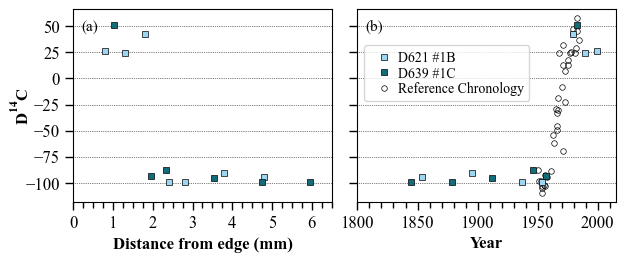

In [18]:
#Radiocarbon figure
import math

#import Sur Ridge radiocarbon results and reference chronology data
radiocarbon_sr=pd.read_csv('datasets/14C_surridge.csv')
radiocarbon_sr=radiocarbon_sr.merge(bulk_data.loc[:,['Age Model','Coral ID','Sample #']],
                                    on=['Coral ID','Sample #'],how='left').dropna(axis=1)

# import reference chronology from Haltuch et al., 2013
radiocarbon_ref=pd.read_csv('datasets/Haltuch_et_al_2013_referencechronology.csv')
# calculate fraction modern in reference chronology
radiocarbon_ref['F14C']=((radiocarbon_ref['Delta14C']/1000)+1)/np.exp((1/8267)*(1950-radiocarbon_ref['Birth Year']))
# calculate D14C in reference chronology
radiocarbon_ref['D14C']=(radiocarbon_ref['F14C']-1)*1000

# plot font size
plt.rcParams.update({'font.size': 12})

#initialize plot
fig,axs=plt.subplots(1,2,figsize=(full_width,2.5),sharey=True)
fig.subplots_adjust(wspace=0.1)

#plot distance from edge vs D14C
axs[0].plot(radiocarbon_sr[radiocarbon_sr['Coral ID']=='D621_1B']['Distance from edge (mm)'],
            radiocarbon_sr[radiocarbon_sr['Coral ID']=='D621_1B']['D14C'],
            linestyle='None',marker='s',markersize=5,mec='k',mew=.5,color='#9CD6F3')
axs[0].plot(radiocarbon_sr[radiocarbon_sr['Coral ID']=='D639_1C']['Distance from edge (mm)'],
            radiocarbon_sr[radiocarbon_sr['Coral ID']=='D639_1C']['D14C'],
            linestyle='None',marker='s',markersize=5,mec='k',mew=.5,color='#126C7A')

#plot Age model vs D14C with reference chronology from Haltuch et al., 2013
axs[1].plot(radiocarbon_sr[radiocarbon_sr['Coral ID']=='D621_1B']['Age Model'],
            radiocarbon_sr[radiocarbon_sr['Coral ID']=='D621_1B']['D14C'],
            linestyle='None',marker='s',markersize=5,mec='k',mew=.5,color='#9CD6F3',
            label='D621 #1B')
axs[1].plot(radiocarbon_sr[radiocarbon_sr['Coral ID']=='D639_1C']['Age Model'],
            radiocarbon_sr[radiocarbon_sr['Coral ID']=='D639_1C']['D14C'],
            linestyle='None',marker='s',markersize=5,mec='k',mew=.5,color='#126C7A',
            label='D639 #1C')
axs[1].plot(radiocarbon_ref['Birth Year'],
            radiocarbon_ref['D14C'],
            linestyle='None',marker='o',
            markersize=4,mec='k',
            mew=.5,color='None',zorder=-5,
            label='Reference Chronology')

#configure ticks
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(25))

axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

axs[1].xaxis.set_major_locator(ticker.MultipleLocator(50))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(10))

#set x and y limits
axs[0].set_xlim(0,6.5)
axs[1].set_xlim(1800,2015)

#set axis labels
axs[0].set_ylabel('$\mathdefault{D^{14}C}$',weight='semibold',labelpad=-5)
axs[0].set_xlabel('Distance from edge (mm)',weight='semibold')
axs[1].set_xlabel('Year',weight='semibold')

#add gridlines
axs[0].grid(linestyle=':',color='k',axis='y',lw=.5)
axs[1].grid(linestyle=':',color='k',axis='y',lw=.5)

#add subplot labels
axs[0].text(0.03,.95,'(a)',ha='left',va='top',
            fontsize=11,color='k',transform=axs[0].transAxes)
axs[1].text(0.03,.95,'(b)',ha='left',va='top',
            fontsize=11,color='k',transform=axs[1].transAxes)

#add legend
axs[1].legend(fontsize=10,labelspacing=0.1,handletextpad=0,
              loc='upper left',bbox_to_anchor=(0,.85))

#save figure, display and close
plt.savefig('figures/FIGS1.pdf', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS1.png', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

### Figure S2 Acidification Test Results

,Coral ID,Sample #,Age Model,d13C_untreated,d13C_acidified
0,D621_1B,19,1974.83,-17.99,-17.71
1,D621_1B,27,1941.50,-17.35,-17.55
2,D621_1B,32,1920.67,-17.20,-17.30
3,D639_1C,11,1977.38,-18.98,-18.73
4,D639_1C,22,1942.95,-17.48,-17.30
5,D639_1C,31,1917.65,-16.18,-16.32


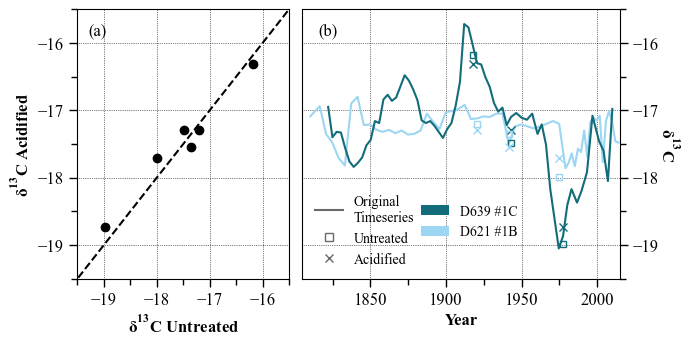

-0.04499999999999934

In [19]:
hcl_test=pd.read_csv('datasets/hcl_fuming_test.csv')
display(hcl_test)

fig,ax=plt.subplots(1,2,figsize=(full_width,half_width),width_ratios=[2,3],sharey='all')
fig.subplots_adjust(wspace=0.05)

#biplot
ax[0].plot(hcl_test[hcl_test['Coral ID']=='D621_1B']['d13C_untreated'],
           hcl_test[hcl_test['Coral ID']=='D621_1B']['d13C_acidified'],
           marker='o',color='k',linestyle='None')
ax[0].plot(hcl_test[hcl_test['Coral ID']=='D639_1C']['d13C_untreated'],
           hcl_test[hcl_test['Coral ID']=='D639_1C']['d13C_acidified'],
           marker='o',color='k',linestyle='None')
ax[0].plot([-20,-15],[-20,-15],color='k',linestyle='--',label='1:1 Line')

#timeseries
ax[1].plot(bulk_D621_1B['Age Model'],bulk_D621_1B['d13C'], color='#9CD6F3',mec='k',linestyle='-',
           markersize=4,mew=.5)
ax[1].plot(bulk_D639_1C['Age Model'],bulk_D639_1C['d13C'], color='#126C7A',mec='k',linestyle='-',
           markersize=4,mew=.5)

ax[1].plot(hcl_test[hcl_test['Coral ID']=='D621_1B']['Age Model'],
           hcl_test[hcl_test['Coral ID']=='D621_1B']['d13C_untreated'], 
           color='None',mec='#9CD6F3',linestyle='None',
           marker='s',markersize=4,mew=1,zorder=10)
ax[1].plot(hcl_test[hcl_test['Coral ID']=='D639_1C']['Age Model'],
           hcl_test[hcl_test['Coral ID']=='D639_1C']['d13C_untreated'], 
           color='None',mec='#126C7A',linestyle='None',
           marker='s',markersize=4,mew=1)

ax[1].plot(hcl_test[hcl_test['Coral ID']=='D621_1B']['Age Model'],
           hcl_test[hcl_test['Coral ID']=='D621_1B']['d13C_acidified'],
           color='#9CD6F3',mec='#9CD6F3',linestyle='None',
           marker='x',markersize=6,mew=1)
ax[1].plot(hcl_test[hcl_test['Coral ID']=='D639_1C']['Age Model'],
           hcl_test[hcl_test['Coral ID']=='D639_1C']['d13C_acidified'], 
           color='#126C7A',mec='#126C7A',linestyle='None',
           marker='x',markersize=6,mew=1)

#set axis labels
ax[0].set_xlabel('$\mathdefault{δ^{13}C}$ Untreated', weight='semibold')
ax[0].set_ylabel('$\mathdefault{δ^{13}C}$ Acidified', weight='semibold')

ax[1].set_xlabel('Year', weight='semibold')
ax[1].tick_params(which='both',labelleft=False,left=False,right=True,labelright=True)
ax[1].set_ylabel('$\mathdefault{δ^{13}C}$', rotation=270,labelpad=15,weight='semibold')
ax[1].yaxis.set_label_position('right')

#configure ticks, axes, etc
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(.5))

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(.5))

ax[1].xaxis.set_major_locator(ticker.MultipleLocator(50))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(25))

ax[0].set_xlim(-19.5,-15.5)
ax[0].set_ylim(-19.5,-15.5)
ax[1].set_xlim(1805,2015)

ax[0].grid(linestyle=':',color='k',lw=0.5)
ax[1].grid(linestyle=':',color='k',lw=0.5)

#subplot labels
ax[0].text(0.05,.95,'(a)',ha='left',va='top',transform = ax[0].transAxes)
ax[1].text(0.05,.95,'(b)',ha='left',va='top',transform = ax[1].transAxes)

#symbols for legend
ax[1].bar(2100,20,color='#126C7A',width=1.2,label='D639 #1C')
ax[1].bar(2100,20,color='#9CD6F3',width=1.2,label='D621 #1B')
ax[1].plot([0,1],[0,1],color='dimgrey',label='Original\nTimeseries')
ax[1].plot([0],[0],linestyle='none',marker='s',mec='dimgrey',color='None',label='Untreated')
ax[1].plot([0],[0],linestyle='none',marker='x',color='dimgrey',label='Acidified')

ax[1].legend(loc='lower left',bbox_to_anchor=(0,0),fontsize=10,frameon=False,ncols=2,columnspacing=0.5)

plt.savefig('figures/FIGS2.pdf', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS2.png', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

hcl_test['offset']=hcl_test['d13C_untreated']-hcl_test['d13C_acidified']
hcl_test['offset'].mean()

### Figure S3

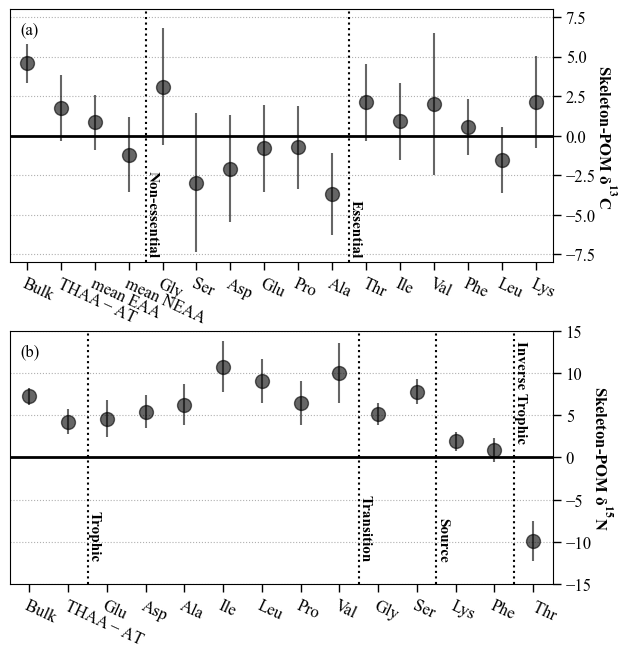

In [20]:
# AA pattern figure C and N plot: mean skeleton-sed trap offset

plt.rcParams.update({'font.size': 12})

#carbon part of plot

#select variables of interest to plot and set labels
AA_list_Shen=['Bulk','d13C THAA atomic','avg essential','avg nonessential',
              'Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']
AA_list_SR=['d13C','d13C THAA atomic','avg essential','avg nonessential',
            'Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']
label_list=['Bulk','$\mathdefault{THAA-AT}$','mean EAA','mean NEAA',
            'Gly', 'Ser', 'Asp','Glu','Pro', 'Ala','Thr','Ile','Val','Phe','Leu','Lys']

#for each variable selected above, subtract mean sed trap values from mean coral values and propagate error 
AA_d13C_means=np.asarray(AA_d13C.loc[:,AA_list_SR].mean())-np.asarray(sedtrap_d13C.loc[:,AA_list_Shen].mean())
AA_d13C_std=(((np.asarray(AA_d13C.loc[:,AA_list_SR].std()))**2)+((np.asarray(sedtrap_d13C.loc[:,AA_list_Shen].std()))**2))**0.5

#initialize plot
fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(full_width,8/7.5*full_width))
fig.subplots_adjust(hspace=0.27)

#plot mean coral minus sed trap value for each variable selected above
vals=np.arange(0,len(AA_list_SR),1)
ax[0].errorbar(x=vals,y=AA_d13C_means,yerr=AA_d13C_std,linestyle='None',
            color='k',marker='o',markersize=10,capsize=0, alpha=.6,label='Mean±std',zorder=2)

#configure misc plot settings
ax[0].axhline(0,linestyle='-',color='k',lw=2)

ax[0].set_xticks(vals)
ax[0].set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')

ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()

ax[0].set_xlim(-0.5,15.5)
ax[0].set_ylim(-8,8)

ax[0].grid(axis='y', linestyle=':',zorder=-5)

ax[0].set_ylabel('Skeleton-POM '+'$\mathdefault{δ^{13}C}$',weight='bold',rotation=270,labelpad=15)

#add annotations labeling essential and non-essential AAs
ax[0].axvline(x=3.5, color='k',linestyle=':')
ax[0].axvline(x=9.5, color='k',linestyle=':')

ax[0].text(3.5, -7.5, 'Non-essential', weight='bold',fontsize=11,rotation=270)
ax[0].text(9.5, -7.5, 'Essential', weight='bold',fontsize=11,rotation=270)

#nitrogen part of plot

#select variables of interest to plot and set labels
AA_list_Shen=['Bulk','d15N THAA atomic','Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']
AA_list_SR=['d15N','d15N THAA atomic', 'Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']
label_list=['Bulk ','$\mathdefault{THAA-AT}$', 'Glu', 'Asp', 'Ala','Ile','Leu','Pro','Val','Gly','Ser','Lys','Phe', ' Thr']

#for each variable selected above, subtract mean sed trap values from mean coral values and propagate error 
AA_d15N_means=np.asarray(AA_d15N.loc[:,AA_list_SR].mean())-np.asarray(sedtrap_d15N.loc[:,AA_list_Shen].mean())
AA_d15N_std=(((np.asarray(AA_d15N.loc[:,AA_list_SR].std()))**2)+((np.asarray(sedtrap_d15N.loc[:,AA_list_Shen].std()))**2))**0.5

#plot mean coral minus sed trap value for each variable selected above
vals=np.arange(0,len(label_list),1)
ax[1].errorbar(x=vals,y=AA_d15N_means,yerr=AA_d15N_std,linestyle='None',
            color='k',marker='o',markersize=10,capsize=0, alpha=0.6, label='Mean±std',zorder=2)

#configure misc plot settings
ax[1].axhline(0,linestyle='-',color='k',lw=2)

ax[1].set_xticks(vals)
ax[1].set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')

ax[1].set_yticks(np.arange(-15,30.01,5))
ax[1].set_ylabel('Skeleton-POM '+'$\mathdefault{δ^{15}N}$',weight='bold',rotation=270,labelpad=15)

ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

ax[1].set_xlim(-0.5,13.5)
ax[1].set_ylim(-15,15)
ax[1].grid(axis='y', linestyle=':',zorder=-5)

#add annotations labeling AA groups (trophic, source, etc)
ax[1].axvline(x=1.5, color='k',linestyle=':')
ax[1].axvline(x=8.5, color='k',linestyle=':')
ax[1].axvline(x=10.5, color='k',linestyle=':')
ax[1].axvline(x=12.5, color='k',linestyle=':')

ax[1].text(1.5, -12, 'Trophic', weight='bold',fontsize=11,rotation=270)
ax[1].text(8.5, -12, 'Transition', weight='bold',fontsize=11,rotation=270)
ax[1].text(10.5, -12, 'Source', weight='bold',fontsize=11,rotation=270)
ax[1].text(12.5, 2, 'Inverse Trophic', weight='bold',fontsize=11,rotation=270)

#subplot labels
ax[0].text(0.02,.95,'(a)',ha='left',va='top',transform = ax[0].transAxes)
ax[1].text(0.02,.95,'(b)',ha='left',va='top',transform = ax[1].transAxes)

#save figure, display and close
plt.savefig('figures/FIGS3.pdf', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS3.png', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()


### Figure S4

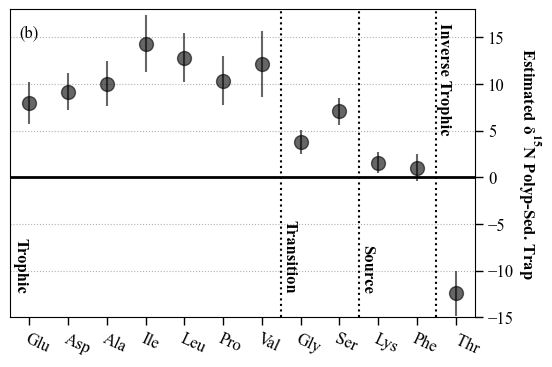

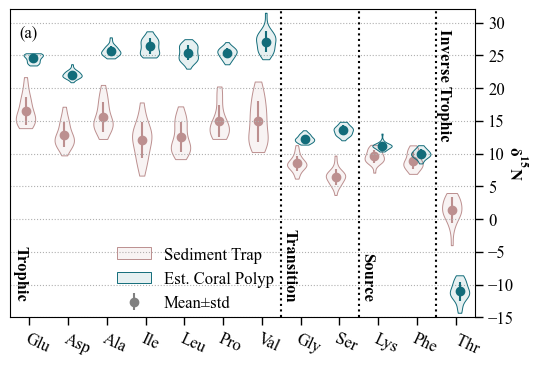

In [21]:
#for comparing estimated polyp AA d15N values to Shen et al sediment traps

#set font size
plt.rcParams.update({'font.size': 12})

#select variables to plot and corresponding labels
AA_list_Shen=['Glu', 'Asp', 'Ala','Ile','Leu','Pro+Hpro','Val','Gly','Ser','Lys','Phe', 'Thr']
AA_list_SR=['Glu_polyp', 'Asp_polyp', 'Ala_polyp','Ile_polyp','Leu_polyp','Pro_polyp','Val_polyp','Gly_polyp','Ser_polyp','Lys_polyp','Phe_polyp', 'Thr_polyp']
label_list=['Glu', 'Asp', 'Ala','Ile','Leu','Pro','Val','Gly','Ser','Lys','Phe', ' Thr']

#for each variable selected above, subtract mean sed trap values from estimated coral polyp values and propagate error 
AA_d15N_means=np.asarray(AA_d15N.loc[:,AA_list_SR].mean())-np.asarray(sedtrap_d15N.loc[:,AA_list_Shen].mean())
AA_d15N_std=(((np.asarray(AA_d15N.loc[:,AA_list_SR].std()))**2)+((np.asarray(sedtrap_d15N.loc[:,AA_list_Shen].std()))**2))**0.5

#initialize figure (mean differences between estimated poly and sediment trap)
fig,ax=plt.subplots(figsize=(6,4))

#plot mean estimated coral polyp minus sed trap value for each variable selected above
vals=np.arange(0,len(AA_list_SR),1)
ax.errorbar(x=vals,y=AA_d15N_means,yerr=AA_d15N_std,linestyle='None',
            color='k',marker='o',markersize=10,capsize=0,alpha=0.6, label='Mean±std',zorder=2)

#various plot settings
ax.set_xticks(np.arange(0,len(AA_list_SR),1))
ax.set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')

ax.set_yticks(np.arange(-15,30.01,5))
ax.set_ylabel('Estimated $\mathdefault{δ^{15}N}$ Polyp-Sed. Trap',weight='bold',labelpad=20,rotation=270)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.set_ylim(-15,18)
ax.set_xlim(-0.5,11.5)

ax.grid(axis='y', linestyle=':',zorder=-5)

ax.axhline(0,linestyle='-',color='k',lw=2)

#add annotations labeling AA groups (trophic, source, etc)
ax.axvline(x=6.5, color='k',linestyle=':')
ax.axvline(x=8.5, color='k',linestyle=':')
ax.axvline(x=10.5, color='k',linestyle=':')

ax.text(-0.45, -12, 'Trophic', weight='bold',rotation=270)
ax.text(6.5, -12, 'Transition', weight='bold',rotation=270)
ax.text(8.5, -12, 'Source', weight='bold',rotation=270)
ax.text(10.5, 5, 'Inverse Trophic', weight='bold',rotation=270)

#subplot label
ax.text(0.02,.95,'(b)',ha='left',va='top',transform = ax.transAxes)

#save panel b figure and close
plt.savefig('figures/FIGS4_panelb.png', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS4_panelb.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

# AA violin plot pattern figure with estimated polyps compared to Yuan sed trap data
offset=-0.1
sedcolor='#BC8F8F'
coralcolor='#126C7A'
    
#initialize figure
fig,ax=plt.subplots(figsize=(6,4))

#plot violin plots for each variable selected above from sed traps and sur ridge coral specimens
vals=np.arange(0,len(label_list),1)
violin_custom(sedtrap_d15N.loc[:,AA_list_Shen].dropna(),pos=vals+offset,facecolor=sedcolor,axis=ax,z=-5, label='Sediment Trap')
violin_custom(AA_d15N.loc[:,AA_list_SR],vals-offset,facecolor=coralcolor,axis=ax,z=5, label='Est. Coral Polyp')

#set misc plot settings
ax.set_xticks(vals)
ax.set_xticklabels(label_list,rotation=-25,ha='left', rotation_mode='anchor')

ax.set_yticks(np.arange(-15,30.01,5))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.set_xlim(-0.5,11.5)
ax.set_ylim(-15,32)
ax.grid(axis='y', linestyle=':',zorder=-5)

ax.set_ylabel('$\mathdefault{δ^{15}N}$',weight='bold',labelpad=10,rotation=270)

#add annotations labeling AA groupings (trophic, source, etc)
ax.axvline(x=6.5, color='k',linestyle=':')
ax.axvline(x=8.5, color='k',linestyle=':')
ax.axvline(x=10.5, color='k',linestyle=':')

ax.text(-0.45, -12, 'Trophic', weight='bold',rotation=270)
ax.text(6.5, -12, 'Transition', weight='bold',rotation=270)
ax.text(8.5, -12, 'Source', weight='bold',rotation=270)
ax.text(10.5, 12.5, 'Inverse Trophic', weight='bold',rotation=270)

#plot extra symbol outside axis bounds to use for mean +/- std legend symbol and add legend
ax.errorbar(x=[-100],y=[-100],yerr=[1.5],color='gray',linestyle='None',marker='o',label='Mean±std')
ax.legend(facecolor='None', loc='lower right', bbox_to_anchor=(.6,-.03), frameon=False)

#subplot label
ax.text(0.02,.95,'(a)',ha='left',va='top',transform = ax.transAxes)

#save panel a figure and close
plt.savefig('figures/FIGS4_panela.pdf', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS4_panela.png', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

### Figure S5

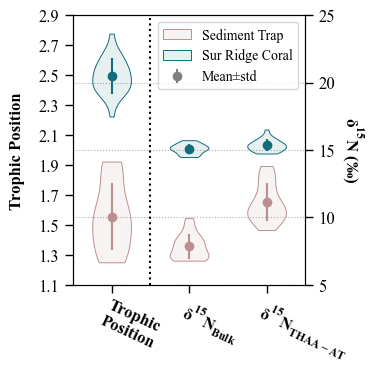

In [22]:
# Trophic relationships interpretation figure

#set fontsize
plt.rcParams.update({'font.size': 12})

#select colors
sedcolor='#BC8F8F'
coralcolor='#126C7A'#'#126C7A'#'#79A6BD'#

#select variables of interest and set x axis labels
AA_list_Shen=['Bulk','d15N THAA atomic','Glu','Phe']
AA_list_SR=['d15N','d15N THAA atomic', 'Glu','Phe']
label_list=['Trophic\nPosition','$\mathdefault{δ^{15}N_{Bulk}}$','$\mathdefault{δ^{15}N_{THAA-AT}}$', '$\mathdefault{δ^{15}N_{Glu}}$','$\mathdefault{δ^{15}N_{Phe}}$']

#initialize plot 
fig,ax1=plt.subplots(figsize=(3,3.5))
offset=0 #controls horizontal spacing between coral and sed trap violin plots
ax2=ax1.twinx()
vals=np.arange(0,len(label_list),1)

#plot sed trap and Sur Ridge Coral violin plots
violin_custom(sedtrap_d15N.loc[:,AA_list_Shen[1:]].dropna(),pos=vals[2:]+offset,
              facecolor=sedcolor,axis=ax1,z=-5,label='Sediment Trap')
violin_custom(sedtrap_d15N.loc[:,AA_list_Shen[0]].dropna(),pos=[vals[1]+offset],
              facecolor=sedcolor,axis=ax1,z=-5)
violin_custom(sedtrap_d15N.loc[:,'TP'].dropna(),pos=[vals[0]+offset],
              facecolor=sedcolor,axis=ax2,z=-5)

violin_custom(AA_d15N.loc[:,AA_list_SR],vals[1:]-offset,facecolor=coralcolor,axis=ax1,z=5,label='Sur Ridge Coral')
violin_custom(AA_d15N.loc[:,'Coral TP'],pos=[vals[0]-offset],facecolor=coralcolor,axis=ax2,z=5)

#set misc plot settings
ax1.set_xticks(vals)
ax1.set_xticklabels(label_list,rotation=-25,ha='left',rotation_mode='anchor',weight='semibold')

ax1.set_yticks(np.arange(-15,30.01,5))
ax1.set_ylabel('$\mathdefault{δ^{15}N}$ (‰)',rotation=270,weight='semibold',labelpad=22)
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.grid(axis='y', linestyle=':',zorder=-5)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.set_yticks(np.arange(1.1,2.91,0.2))
ax2.set_ylabel('Trophic Position',weight='semibold',labelpad=10)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()
ax2.tick_params(axis='y', which='major', labelsize=12)

ax1.set_xlim(-0.5,2.5)
ax2.set_ylim(1.1,2.9)
ax1.set_ylim(5,25)

#add vertical line to divide TP from other variables 
#since they are plotted on different axes
ax1.axvline(x=0.5, color='k',linestyle=':')

#plot extra symbol outside axis bounds to use for mean +/- std legend symbol and add legend
ax1.errorbar(x=[-100],y=[-100],yerr=[1.5],color='gray',linestyle='None',marker='o',label='Mean±std')
ax1.legend(facecolor='w', loc='upper right', bbox_to_anchor=(1,1),frameon=True,labelspacing=.5,fontsize=10)

#save and close figure
plt.savefig('figures/FIGS5.pdf', dpi=1000,bbox_inches='tight')
plt.savefig('figures/FIGS5.png', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()
